# Moodle survey analysis

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Aggregated numbers

In [2]:
# import courseID - courseName - courseCategory for looping
base_table_path = "C:/Users/ywa/Documents/Data/Moodle Query/Jan2026/KIC-course completion rate.csv"
base_df = pd.read_csv(base_table_path, sep = ';')

print(base_df.info())
base_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   courseID         94 non-null     int64 
 1   Live Courses     94 non-null     object
 2   Course Category  94 non-null     object
dtypes: int64(1), object(2)
memory usage: 2.3+ KB
None


,courseID,Live Courses,Course Category
0,106,Einführung in die KI,Über KI
1,58,AICE your exams – Generative KI als Copilot im...,Studieren
2,99,KI für Alle 1: Einführung in die Künstliche In...,Über KI
3,313,EU AI Act Essentials,Studieren
4,197,KIÖV - KI in öffentlichen Verwaltungen,Studieren


### Import data

In [112]:
# import pre and post surveys --> stack rows together

agg_pre_list = []
agg_post_list = []

pre_DE = "Umfrage_zu_Kursbeginn.csv"
pre_EN = "Start_of_course_Questionnaire.csv"

post_DE = "Umfrage_zum_Kursende.csv"
post_EN = "End_of_course_Questionnaire.csv"

survey_base_path = "C:/Users/ywa/Documents/Data/Moodle User-Survey/Feb_26"

for courseID in base_df['courseID']:
    #pre survey
    file_path_pre_de = os.path.join(survey_base_path, str(courseID), pre_DE)
    file_path_pre_en = os.path.join(survey_base_path, str(courseID), pre_EN)
    
    pre_path = file_path_pre_de if os.path.exists(file_path_pre_de) else (file_path_pre_en if os.path.exists(file_path_pre_en) else None)
    
    if pre_path is None:
        print(f"Warning: Pre survey file not found for courseID = {courseID}")
    else:
        try:
            pre_survey_df = pd.read_csv(pre_path, sep = ',')
            pre_survey_df['courseID'] = courseID
            
            agg_pre_list.append(pre_survey_df)
            
        except Exception as e:
            print(f"Warning: Failed reading {pre_path} for courseID = {courseID}:{e}")
            
    # post survey
    file_path_post_de = os.path.join(survey_base_path, str(courseID), post_DE)
    file_path_post_en = os.path.join(survey_base_path, str(courseID), post_EN)
    
    post_path = file_path_post_de if os.path.exists(file_path_post_de) else (file_path_post_en if os.path.exists(file_path_post_en) else None)
    
    if post_path is None:
        print(f"Warning: Post survey file not found for courseID = {courseID}")
    else:
        try:
            post_survey_df = pd.read_csv(post_path, sep = ',')
            post_survey_df['courseID'] = courseID
            
            agg_post_list.append(post_survey_df)
        
        except Exception as e:
            print(f"Warning: Falid reading {post_path} for courseID = {courseID} : {e}")

agg_pre_df = pd.concat(agg_pre_list, ignore_index = True) if agg_pre_list else pd.DataFrame()
agg_post_df = pd.concat(agg_post_list, ignore_index = True) if agg_post_list else pd.DataFrame()
    

In [113]:
print(agg_pre_df.shape)
print(agg_post_df.shape)

# drop unnecessary columns
agg_pre_df = agg_pre_df.drop(['Response', 'Submitted on:', 'Institution', 'Department', 'Group', 'ID', 'Full name', 'Username'], axis = 1)
agg_post_df = agg_post_df.drop(['Response', 'Submitted on:', 'Institution', 'Department', 'Group', 'ID', 'Full name', 'Username'], axis = 1)

# drop unnecessary columns
agg_pre_df = agg_pre_df.drop(['Antworten', 'Abgegeben:', 'Abteilung', 'Gruppe', 'Nutzer-ID', 'Vollständiger Name', 'Anmeldename'], axis = 1)
agg_post_df = agg_post_df.drop(['Antworten', 'Abgegeben:', 'Abteilung', 'Gruppe', 'Nutzer-ID', 'Vollständiger Name', 'Anmeldename'], axis = 1)


(19750, 148)
(11101, 209)


In [114]:
print(agg_pre_df.info())
print(agg_pre_df.shape)
print(agg_pre_df.isnull().sum().shape)

print(agg_post_df.info())
print(agg_post_df.shape)
print(agg_post_df.isnull().sum().shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19750 entries, 0 to 19749
Columns: 133 entries, Course to Q06_Question 6->I’d rather not answer
dtypes: float64(129), int64(1), object(3)
memory usage: 20.0+ MB
None
(19750, 133)
(133,)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11101 entries, 0 to 11100
Columns: 194 entries, Course to Q09_Anregungen
dtypes: float64(187), int64(1), object(6)
memory usage: 16.4+ MB
None
(11101, 194)
(194,)


In [102]:
print(len(pd.unique(agg_pre_df.columns)))
print(len(pd.unique(agg_post_df.columns)))

140
201


### Preprocessing

In [135]:
# list cols for standarisation

pre_en_cols = ['Course', \
               'Q01_Question 1->I’m interested in the course topic.', \
               'Q01_Question 1->I want to earn a certificate (e.g. Record of Participation / Achievement).', \
               'Q01_Question 1->It’s part of my university studies (e.g. a required or elective course).', \
               'Q01_Question 1->I want to deepen my knowledge for professional development.', \
               'Q01_Question 1->I’m pursuing a higher professional qualification or career change.', \
               'Q01_Question 1->I already have prior knowledge and am looking to refresh or expand it.', \
               'Q01_Question 1->I want to use the course materials in my own teaching.', \
               'Q01_Question 1->Other', 'Q02_Question 2->Foundations of AI', \
               'Q02_Question 2->Machine Learning', \
               'Q02_Question 2->Natural Language Processing / Large Language Models (NLP / LLMs)', \
               'Q02_Question 2->Data Science', 'Q02_Question 2->Data Literacy', \
               'Q02_Question 2->Robotics', \
               'Q02_Question 2->Human-AI Interaction (e.g. Human-Computer Interaction)', \
               'Q02_Question 2->Internet of Things (IoT) & Industry 4.0', \
               'Q02_Question 2->Other', 'Q03_Question 3->AI in Healthcare', \
               'Q03_Question 3->AI in Education', \
               'Q03_Question 3->AI in Public Administration', \
               'Q03_Question 3->AI for Business & Management', \
               'Q03_Question 3->Ethical and Societal Questions Related to AI', \
               'Q03_Question 3->Other', 'Q04_Question 4->Male', 'Q04_Question 4->Female', 'Q04_Question 4->Diverse', \
               'Q04_Question 4->I’d rather not answer', \
               'Q05_Question 5->Doctorate / PhD', \
               'Q05_Question 5->Master’s degree or equivalent (e.g. Diplom, Magister, postgraduate university degree)', \
               'Q05_Question 5->Bachelor’s degree or equivalent (e.g. B.Sc., B.A., vocational university degree)', \
               'Q05_Question 5->Completed vocational or professional training (e.g. apprenticeship, business school, technical college)', \
               'Q05_Question 5->Upper secondary school certificate (e.g. Abitur, A Levels, Mittlere Reife, GCSEs)', \
               'Q05_Question 5->Lower secondary school certificate (e.g. Realschule, Hauptschule, basic secondary education)', \
               'Q05_Question 5->No formal school-leaving certificate or training', \
               'Q05_Question 5->I’d rather not answer', \
               'Q06_Question 6->Manufacturing, Construction, or Engineering', \
               'Q06_Question 6->Trade, Transport, or Logistics', \
               'Q06_Question 6->Information Technology or Media', \
               'Q06_Question 6->Finance, Insurance, or Real Estate', \
               'Q06_Question 6->Healthcare or Social Services', \
               'Q06_Question 6->Education, Research, or Childcare', \
               'Q06_Question 6->Public Administration or Government', \
               'Q06_Question 6->Hospitality or Tourism', \
               'Q06_Question 6->Other Services', \
               'Q06_Question 6->Other / None of the above', \
               'Q06_Question 6->I’d rather not answer']

post_en_cols = ['Course', \
                'Q01_Question 1->Very good', \
                'Q01_Question 1->Good', 'Q01_Question 1->Average', \
                'Q01_Question 1->Bad', 'Q01_Question 1->Very bad', \
                'Q02_Question 2->Yes', 'Q02_Question 2->No', \
                'Q03_Question 3->The content was not accurate or up-to-date', \
                'Q03_Question 3->The explanations or structure were hard to follow (didactics)', \
                'Q03_Question 3->The course design or layout made it difficult to navigate', \
                'Q03_Question 3->The level of the course did not match my expectations', \
                'Q03_Question 3->The course did not meet my learning goals', \
                'Q03_Question 3->The technical quality (videos, platform, interactions) was poor', \
                'Q03_Question 3->Other', 'Q04_Question 4->Completely', \
                'Q04_Question 4->Mostly', 'Q04_Question 4->Partly', \
                'Q04_Question 4->Not really', 'Q04_Question 4->Not at all', \
                'Q05_Question 5->Extensive', 'Q05_Question 5->Somewhat extensive', \
                'Q05_Question 5->Average', 'Q05_Question 5->Somewhat limited', \
                'Q05_Question 5->Limited', 'Q06_Question 6->Extensive', \
                'Q06_Question 6->Somewhat extensive', 'Q06_Question 6->Average', \
                'Q06_Question 6->Somewhat limited', 'Q06_Question 6->Limited', \
                'Q07_Question 7->Short videos or video lectures', \
                'Q07_Question 7->Written explanations or reading materials', \
                'Q07_Question 7->Practice exercises (e.g. programming tasks, quizzes)', \
                'Q07_Question 7->Visual aids (e.g. diagrams, infographics, simulations)', \
                'Q07_Question 7->Final test or exam', \
                'Q07_Question 7->Peer discussion or forum participation', \
                'Q07_Question 7->AI Chatbot (KI-Lernassistent)', \
                'Q07_Question 7->Other', 'Q08_Question 8->Very helpful', \
                'Q08_Question 8->Helpful', 'Q08_Question 8->Neutral', \
                'Q08_Question 8->Not very helpful', \
                'Q08_Question 8->Not helpful at all', \
                'Q08_Question 8->I haven’t used it', \
                'Q09_Question 9->To get explanations of specific concepts', \
                'Q09_Question 9->To summarise course content (e.g. texts, videos, exercises)', \
                'Q09_Question 9->To get content recommendations or navigation help', \
                'Q09_Question 9->To prepare for quizzes or the final test', \
                'Q09_Question 9->To help with programming tasks or exercises', \
                'Q09_Question 9->To ask administrative or organisational questions', \
                'Q09_Question 9->I tried it out, but didn’t use it seriously', \
                'Q09_Question 9->I didn’t use the chatbot', \
                'Q09_Question 9->Other (please specify)', 'Q10_Question 10->Female', \
                'Q10_Question 10->Male', 'Q10_Question 10->Other', \
                'Q10_Question 10->I’d rather not answer', \
                'Q11_Question 11->Doctorate / PhD', \
                'Q11_Question 11->Master’s degree or equivalent (e.g. Diplom, Magister, postgraduate university degree)', \
                'Q11_Question 11->Bachelor’s degree or equivalent (e.g. B.Sc., B.A., vocational university degree)', \
                'Q11_Question 11->Completed vocational or professional training (e.g. apprenticeship, business school, technical college)', \
                'Q11_Question 11->Upper secondary school certificate (e.g. Abitur, A Levels, Mittlere Reife, GCSEs)', \
                'Q11_Question 11->Lower secondary school certificate (e.g. Realschule, Hauptschule, basic secondary education)', \
                'Q11_Question 11->No formal school-leaving certificate or training', \
                'Q11_Question 11->I’d rather not answer', \
                'Q12_Question 12->Manufacturing, Construction, or Engineering', \
                'Q12_Question 12->Trade, Transport, or Logistics', \
                'Q12_Question 12->Information Technology or Media', \
                'Q12_Question 12->Finance, Insurance, or Real Estate', \
                'Q12_Question 12->Healthcare or Social Services', \
                'Q12_Question 12->Education, Research, or Childcare', \
                'Q12_Question 12->Public Administration or Government', \
                'Q12_Question 12->Hospitality or Tourism', \
                'Q12_Question 12->Other Services', \
                'Q12_Question 12->Other / None of the above', \
                'Q12_Question 12->I’d rather not answer']

pre_de_cols = ['Course', \
               'Q01_Question 1->Ich interessiere mich für das Kursthema.', \
               'Q01_Question 1->Ich möchte ein Zertifikat erhalten (zB. Teilnahmebestätigung, Leistungsnachweis).', \
               'Q01_Question 1->Es ist Teil meines Universitätsstudiums (z. B. ein Pflicht- oder Wahlfach).', \
               'Q01_Question 1->Ich möchte mein Wissen zur beruflichen Weiterentwicklung vertiefen.', \
               'Q01_Question 1->Ich strebe eine berufliche Höherqualifizierung oder einen Berufswechsel an.', \
               'Q01_Question 1->Ich verfüge bereits über Vorkenntnisse und möchte diese auffrischen oder erweitern.', \
               'Q01_Question 1->Ich möchte die Kursmaterialien in meinem eigenen Unterricht verwenden.', \
               'Q01_Question 1->Sonstiges', 'Q02_Question 2->Grundlagen der KI', \
               'Q02_Question 2->Maschinelles Lernen', \
               'Q02_Question 2->Natural Language Processing / Large Language Models (NLP / LL.M.)', \
               'Q02_Question 2->Data Science', 'Q02_Question 2->Datenkompetenz', \
               'Q02_Question 2->Robotik', \
               'Q02_Question 2->Mensch-KI-Interaktion (z. B. Mensch-Computer-Interaktion)', \
               'Q02_Question 2->Internet der Dinge (IoT) & Industrie 4.0', \
               'Q02_Question 2->Sonstiges', 'Q03_Question 3->KI im Gesundheitswesen', \
               'Q03_Question 3->KI im Bildungswesen', \
               'Q03_Question 3->KI in der öffentlichen Verwaltung', \
               'Q03_Question 3->KI für Wirtschaft und Management', \
               'Q03_Question 3->Ethische und gesellschaftliche Fragen im Zusammenhang mit KI', \
               'Q03_Question 3->Sonstiges', 'Q04_Question 4->Männlich', \
               'Q04_Question 4->Weiblich', 'Q04_Question 4->Divers', \
               'Q04_Question 4->Ich möchte diese Frage nicht beantworten', \
               'Q05_Question 5->Promotion', \
               'Q05_Question 5->Masterabschluss oder gleichwertiger Abschluss (z. B. Diplom, Magister, postgradualer Hochschulabschluss)', \
               'Q05_Question 5->Bachelorabschluss oder gleichwertiger Abschluss (z. B. B.Sc., B.A., Fachhochschulabschluss)', \
               'Q05_Question 5->Abgeschlossene Berufsausbildung (z. B. Lehre, Handelsschule, Fachoberschule)', \
               'Q05_Question 5->Abitur (z. B. Abitur, Mittlere Reife, GCSE)', \
               'Q05_Question 5->Hauptschulabschluss (z. B. Realschule, Hauptschule)', \
               'Q05_Question 5->Kein Schulabschluss oder Ausbildung', \
               'Q05_Question 5->Ich möchte diese Frage nicht beantworten', \
               'Q06_Question 6->Fertigung, Bauwesen oder Ingenieurwesen', \
               'Q06_Question 6->Handel, Transport oder Logistik', \
               'Q06_Question 6->Informationstechnologie oder Medien', \
               'Q06_Question 6->Finanzen, Versicherungen oder Immobilien', \
               'Q06_Question 6->Gesundheits- oder Sozialwesen', \
               'Q06_Question 6->Bildung, Forschung oder Kinderbetreuung', \
               'Q06_Question 6->Öffentliche Verwaltung oder Regierung', \
               'Q06_Question 6->Gastgewerbe oder Tourismus', \
               'Q06_Question 6->Sonstige Dienstleistungen', \
               'Q06_Question 6->Sonstige / Keine der oben genannten', \
               'Q06_Question 6->Ich möchte lieber nicht antworten']

post_de_cols = ['Course', \
                'Q01_Question 1->Sehr gut', \
                'Q01_Question 1->Gut', 'Q01_Question 1->Durchschnittlich', \
                'Q01_Question 1->Schlecht', 'Q01_Question 1->Sehr schlecht', \
                'Q02_Question 2->Ja', 'Q02_Question 2->Nein', \
                'Q03_Question 3->Die Inhalte waren nicht korrekt oder aktuell.', \
                'Q03_Question 3->Die Erklärungen oder die Struktur waren schwer verständlich (Didaktik).', \
                'Q03_Question 3->Das Kursdesign oder -layout erschwerte die Navigation.', \
                'Q03_Question 3->Das Kursniveau entsprach nicht meinen Erwartungen.', \
                'Q03_Question 3->Der Kurs entsprach nicht meinen Lernzielen.', \
                'Q03_Question 3->Die technische Qualität (Videos, Plattform, Interaktionen) war mangelhaft.', \
                'Q03_Question 3->Sonstiges', 'Q04_Question 4->Vollständig', \
                'Q04_Question 4->Größtenteils', 'Q04_Question 4->Teilweise', \
                'Q04_Question 4->Nicht wirklich', 'Q04_Question 4->Überhaupt nicht', \
                'Q05_Question 5->Umfangreich', 'Q05_Question 5->Etwas umfangreich', \
                'Q05_Question 5->Durchschnittlich', \
                'Q05_Question 5->Etwas eingeschränkt', 'Q05_Question 5->Eingeschränkt', \
                'Q06_Question 6->Umfangreich', 'Q06_Question 6->Etwas umfangreich', \
                'Q06_Question 6->Durchschnittlich', \
                'Q06_Question 6->Etwas eingeschränkt', 'Q06_Question 6->Eingeschränkt', \
                'Q07_Question 7->Kurze Videos oder Videovorträge', \
                'Q07_Question 7->Schriftliche Erklärungen oder Lesematerial', \
                'Q07_Question 7->Übungen (z. B. Programmieraufgaben, Quizze)', \
                'Q07_Question 7->Visuelle Hilfsmittel (z. B. Diagramme, Infografiken, Simulationen)', \
                'Q07_Question 7->Abschlusstest oder Prüfung', \
                'Q07_Question 7->Diskussion mit anderen Teilnehmern oder Teilnahme am Forum', \
                'Q07_Question 7->KI-Chatbot (KI-Lernassistent)', \
                'Q07_Question 7->Sonstiges', 'Q08_Question 8->Sehr hilfreich', \
                'Q08_Question 8->Hilfreich', 'Q08_Question 8->Neutral', \
                'Q08_Question 8->Nicht sehr hilfreich', \
                'Q08_Question 8->Gar nicht hilfreich', \
                'Q08_Question 8->Ich habe ihn nicht genutzt', \
                'Q09_Question 9->Um Erklärungen zu bestimmten Konzepten zu erhalten', \
                'Q09_Question 9->Um Kursinhalte (z. B. Texte, Videos, Übungen) zusammenzufassen', \
                'Q09_Question 9->Um Inhaltsempfehlungen oder Navigationshilfen zu erhalten', \
                'Q09_Question 9->Um sich auf Quizze oder die Abschlussprüfung vorzubereiten', \
                'Q09_Question 9->Um bei Programmieraufgaben oder Übungen zu helfen', \
                'Q09_Question 9->Um administrative oder organisatorische Fragen zu stellen', \
                'Q09_Question 9->Ich habe es ausprobiert, aber nicht ernsthaft genutzt', \
                'Q09_Question 9->Ich habe den Chatbot nicht genutzt', \
                'Q09_Question 9->Sonstiges (bitte angeben)', \
                'Q10_Question 10->Weiblich', 'Q10_Question 10->Männlich', \
                'Q10_Question 10->Divers', \
                'Q10_Question 10->Ich möchte diese Frage nicht beantworten', \
                'Q11_Question 11->Promotion', \
                'Q11_Question 11->Masterabschluss oder gleichwertiger Abschluss (z. B. Diplom, Magister, postgradualer Hochschulabschluss)', \
                'Q11_Question 11->Bachelorabschluss oder gleichwertiger Abschluss (z. B. B.Sc., B.A., Fachhochschulabschluss)', \
                'Q11_Question 11->Abgeschlossene Berufsausbildung (z. B. Lehre, Handelsschule, Fachoberschule)', \
                'Q11_Question 11->Abitur (z. B. Abitur, Mittlere Reife, GCSE)', \
                'Q11_Question 11->Hauptschulabschluss (z. B. Realschule, Hauptschule)', \
                'Q11_Question 11->Kein Schulabschluss oder Ausbildung', \
                'Q11_Question 11->Ich möchte diese Frage nicht beantworten', \
                'Q12_Question 12->Fertigung, Bauwesen oder Ingenieurwesen', \
                'Q12_Question 12->Handel, Transport oder Logistik', \
                'Q12_Question 12->Informationstechnologie oder Medien', \
                'Q12_Question 12->Finanzen, Versicherungen oder Immobilien', \
                'Q12_Question 12->Gesundheits- oder Sozialwesen', \
                'Q12_Question 12->Bildung, Forschung oder Kinderbetreuung', \
                'Q12_Question 12->Öffentliche Verwaltung oder Regierung', \
                'Q12_Question 12->Gastgewerbe oder Tourismus', \
                'Q12_Question 12->Sonstige Dienstleistungen',  \
                'Q12_Question 12->Sonstige / Keine der oben genannten', \
                'Q12_Question 12->Ich möchte lieber nicht antworten']
            

In [136]:
#  create mapping dictionaries
print(len(pre_de_cols), len(pre_en_cols))
print(len(post_de_cols), len(post_en_cols))

en2de_pre = dict(zip(pre_en_cols, pre_de_cols))

en2de_post = dict(zip(post_en_cols, post_de_cols))

# convert one-to-one dictionary to 
en2de_pre = {k : [v] for k, v in en2de_pre.items()}

en2de_post = {k : [v] for k, v in en2de_post.items()}


47 47
76 76


In [138]:
# mapping misalignment
# pre misalignment
mis_en_pre = ['Course', \
               'Q02_Question 2->Foundations of AI', \
               'Q02_Question 2->Machine Learning', \
               'Q02_Question 2->Natural Language Processing / Large Language Models (NLP / LLMs)', \
               'Q02_Question 2->Data Science', 'Q02_Question 2->Data Literacy', \
               'Q02_Question 2->Robotics', \
               'Q02_Question 2->Human-AI Interaction (e.g. Human-Computer Interaction)', \
               'Q02_Question 2->Internet of Things (IoT) & Industry 4.0', \
               'Q02_Question 2->Other', 'Q03_Question 3->AI in Healthcare', \
               'Q03_Question 3->AI in Education', \
               'Q03_Question 3->AI in Public Administration', \
               'Q03_Question 3->AI for Business & Management', \
               'Q03_Question 3->Ethical and Societal Questions Related to AI', \
               'Q03_Question 3->Other', 'Q04_Question 4->Male', 'Q04_Question 4->Female', 'Q04_Question 4->Diverse', \
               'Q04_Question 4->I’d rather not answer', \
               'Q05_Question 5->Doctorate / PhD', \
               'Q05_Question 5->Master’s degree or equivalent (e.g. Diplom, Magister, postgraduate university degree)', \
               'Q05_Question 5->Bachelor’s degree or equivalent (e.g. B.Sc., B.A., vocational university degree)', \
               'Q05_Question 5->Completed vocational or professional training (e.g. apprenticeship, business school, technical college)', \
               'Q05_Question 5->Upper secondary school certificate (e.g. Abitur, A Levels, Mittlere Reife, GCSEs)', \
               'Q05_Question 5->Lower secondary school certificate (e.g. Realschule, Hauptschule, basic secondary education)', \
               'Q05_Question 5->No formal school-leaving certificate or training', \
               'Q05_Question 5->I’d rather not answer', \
               'Q06_Question 6->Manufacturing, Construction, or Engineering', \
               'Q06_Question 6->Trade, Transport, or Logistics', \
               'Q06_Question 6->Information Technology or Media', \
               'Q06_Question 6->Finance, Insurance, or Real Estate', \
               'Q06_Question 6->Healthcare or Social Services', \
               'Q06_Question 6->Education, Research, or Childcare', \
               'Q06_Question 6->Public Administration or Government', \
               'Q06_Question 6->Hospitality or Tourism', \
               'Q06_Question 6->Other Services', \
               'Q06_Question 6->Other / None of the above', \
               'Q06_Question 6->I’d rather not answer']

mis_de_pre = ['Kurs', 'Q03_Question 2->Grundlagen der KI', \
              'Q03_Question 2->Maschinelles Lernen', \
              'Q03_Question 2->Natural Language Processing / Large Language Models (NLP / LL.M.)', \
              'Q03_Question 2->Data Science', 'Q03_Question 2->Datenkompetenz', \
              'Q03_Question 2->Robotik', \
              'Q03_Question 2->Mensch-KI-Interaktion (z. B. Mensch-Computer-Interaktion)', \
              'Q03_Question 2->Internet der Dinge (IoT) & Industrie 4.0', \
              'Q03_Question 2->Sonstiges', 'Q04_Question 3->KI im Gesundheitswesen', \
              'Q04_Question 3->KI im Bildungswesen', \
              'Q04_Question 3->KI in der öffentlichen Verwaltung', \
              'Q04_Question 3->KI für Wirtschaft und Management', \
              'Q04_Question 3->Ethische und gesellschaftliche Fragen im Zusammenhang mit KI', \
              'Q04_Question 3->Sonstiges', 'Q05_Question 4->Männlich', \
              'Q05_Question 4->Weiblich', 'Q05_Question 4->Divers', \
              'Q05_Question 4->Ich möchte diese Frage nicht beantworten', \
              'Q06_Question 5->Promotion', \
              'Q06_Question 5->Masterabschluss oder gleichwertiger Abschluss (z. B. Diplom, Magister, postgradualer Hochschulabschluss)', \
              'Q06_Question 5->Bachelorabschluss oder gleichwertiger Abschluss (z. B. B.Sc., B.A., Fachhochschulabschluss)', \
              'Q06_Question 5->Abgeschlossene Berufsausbildung (z. B. Lehre, Handelsschule, Fachoberschule)', \
              'Q06_Question 5->Abitur (z. B. Abitur, Mittlere Reife, GCSE)', \
              'Q06_Question 5->Hauptschulabschluss (z. B. Realschule, Hauptschule)', \
              'Q06_Question 5->Kein Schulabschluss oder Ausbildung', \
              'Q06_Question 5->Ich möchte diese Frage nicht beantworten', \
              'Q07_Question 6->Fertigung, Bauwesen oder Ingenieurwesen', \
              'Q07_Question 6->Handel, Transport oder Logistik', \
              'Q07_Question 6->Informationstechnologie oder Medien', \
              'Q07_Question 6->Finanzen, Versicherungen oder Immobilien', \
              'Q07_Question 6->Gesundheits- oder Sozialwesen', \
              'Q07_Question 6->Bildung, Forschung oder Kinderbetreuung', \
              'Q07_Question 6->Öffentliche Verwaltung oder Regierung', \
              'Q07_Question 6->Gastgewerbe oder Tourismus', \
              'Q07_Question 6->Sonstige Dienstleistungen', \
              'Q07_Question 6->Sonstige / Keine der oben genannten', \
              'Q07_Question 6->Ich möchte lieber nicht antworten']

# post misalignment
mis_en_post = ['Course', \
              'Q08_Question 8->Very helpful', \
              'Q08_Question 8->Helpful', 'Q08_Question 8->Neutral', \
              'Q08_Question 8->Not very helpful', \
              'Q08_Question 8->Not helpful at all', \
              'Q08_Question 8->I haven’t used it', \
              'Q09_Question 9->To get explanations of specific concepts', \
              'Q09_Question 9->To summarise course content (e.g. texts, videos, exercises)', \
              'Q09_Question 9->To get content recommendations or navigation help', \
              'Q09_Question 9->To prepare for quizzes or the final test', \
              'Q09_Question 9->To help with programming tasks or exercises', \
              'Q09_Question 9->To ask administrative or organisational questions', \
              'Q09_Question 9->I tried it out, but didn’t use it seriously', \
              'Q09_Question 9->I didn’t use the chatbot', \
              'Q09_Question 9->Other (please specify)', 'Q10_Question 10->Female', \
              'Q10_Question 10->Male', 'Q10_Question 10->Other', \
              'Q10_Question 10->I’d rather not answer', \
              'Q11_Question 11->Doctorate / PhD', \
              'Q11_Question 11->Master’s degree or equivalent (e.g. Diplom, Magister, postgraduate university degree)', \
              'Q11_Question 11->Bachelor’s degree or equivalent (e.g. B.Sc., B.A., vocational university degree)', \
              'Q11_Question 11->Completed vocational or professional training (e.g. apprenticeship, business school, technical college)', \
              'Q11_Question 11->Upper secondary school certificate (e.g. Abitur, A Levels, Mittlere Reife, GCSEs)', \
              'Q11_Question 11->Lower secondary school certificate (e.g. Realschule, Hauptschule, basic secondary education)', \
              'Q11_Question 11->No formal school-leaving certificate or training', \
              'Q11_Question 11->I’d rather not answer', \
              'Q12_Question 12->Manufacturing, Construction, or Engineering', \
              'Q12_Question 12->Trade, Transport, or Logistics', \
              'Q12_Question 12->Information Technology or Media', \
              'Q12_Question 12->Finance, Insurance, or Real Estate', \
              'Q12_Question 12->Healthcare or Social Services', \
              'Q12_Question 12->Education, Research, or Childcare', \
              'Q12_Question 12->Public Administration or Government', \
              'Q12_Question 12->Hospitality or Tourism', \
              'Q12_Question 12->Other Services', \
              'Q12_Question 12->Other / None of the above', \
              'Q12_Question 12->I’d rather not answer']

mis_de_post = ['Kurs', 'Q10_Question 8->Sehr hilfreich', 'Q10_Question 8->Hilfreich', \
               'Q10_Question 8->Neutral', 'Q10_Question 8->Nicht sehr hilfreich', \
               'Q10_Question 8->Gar nicht hilfreich', \
               'Q10_Question 8->Ich habe ihn nicht genutzt', \
               'Q11_Question 9->Um Erklärungen zu bestimmten Konzepten zu erhalten', \
               'Q11_Question 9->Um Kursinhalte (z. B. Texte, Videos, Übungen) zusammenzufassen', \
               'Q11_Question 9->Um Inhaltsempfehlungen oder Navigationshilfen zu erhalten', \
               'Q11_Question 9->Um sich auf Quizze oder die Abschlussprüfung vorzubereiten', \
               'Q11_Question 9->Um bei Programmieraufgaben oder Übungen zu helfen', \
               'Q11_Question 9->Um administrative oder organisatorische Fragen zu stellen', \
               'Q11_Question 9->Ich habe es ausprobiert, aber nicht ernsthaft genutzt', \
               'Q11_Question 9->Ich habe den Chatbot nicht genutzt', \
               'Q11_Question 9->Sonstiges (bitte angeben)', \
               'Q12_Question 10->Weiblich', 'Q12_Question 10->Männlich', \
               'Q12_Question 10->Divers',\
               'Q12_Question 10->Ich möchte diese Frage nicht beantworten', \
               'Q13_Question 11->Promotion', \
               'Q13_Question 11->Masterabschluss oder gleichwertiger Abschluss (z. B. Diplom, Magister, postgradualer Hochschulabschluss)', \
               'Q13_Question 11->Bachelorabschluss oder gleichwertiger Abschluss (z. B. B.Sc., B.A., Fachhochschulabschluss)', \
               'Q13_Question 11->Abgeschlossene Berufsausbildung (z. B. Lehre, Handelsschule, Fachoberschule)', \
               'Q13_Question 11->Abitur (z. B. Abitur, Mittlere Reife, GCSE)', \
               'Q13_Question 11->Hauptschulabschluss (z. B. Realschule, Hauptschule)', \
               'Q13_Question 11->Kein Schulabschluss oder Ausbildung', \
               'Q13_Question 11->Ich möchte diese Frage nicht beantworten', \
               'Q14_Question 12->Fertigung, Bauwesen oder Ingenieurwesen', \
               'Q14_Question 12->Handel, Transport oder Logistik', \
               'Q14_Question 12->Informationstechnologie oder Medien', \
               'Q14_Question 12->Finanzen, Versicherungen oder Immobilien', \
               'Q14_Question 12->Gesundheits- oder Sozialwesen', \
               'Q14_Question 12->Bildung, Forschung oder Kinderbetreuung', \
               'Q14_Question 12->Öffentliche Verwaltung oder Regierung', \
               'Q14_Question 12->Gastgewerbe oder Tourismus', \
               'Q14_Question 12->Sonstige Dienstleistungen', \
               'Q14_Question 12->Sonstige / Keine der oben genannten', \
               'Q14_Question 12->Ich möchte lieber nicht antworten']



# create match
mis_pre = dict(zip(mis_en_pre, mis_de_pre))
mis_post = dict(zip(mis_en_post, mis_de_post))


In [139]:
# add values to the existing list

for k, v in mis_pre.items():
    en2de_pre[k].append(v)
        
for k, v in mis_post.items():
    en2de_post[k].append(v)


In [142]:
def standard_df_builder(og_df : pd.DataFrame, map_dic : dict, canonical_cols : list, meta_first :  list | None = None) -> pd.DataFrame:
    meta_first = meta_first or []
    meta_first = [c for c in meta_first if c in og_df.columns]
    
    out = pd.DataFrame(index = og_df.index)
    
    for en_col in canonical_cols:
        candidates = []
        
        if en_col in og_df.columns:
            candidates.append(og_df[en_col])
        
        for de_col in map_dic.get(en_col, []):
            if de_col in og_df.columns:
                candidates.append(og_df[de_col])
                
        if not candidates:
            out[en_col] = pd.NA
        
        else:
            out[en_col] = pd.concat(candidates, axis = 1).bfill(axis = 1).iloc[: , 0]
            
    canonical_set = set(canonical_cols)
    de_cols4map = set()
    for val_list in map_dic.values():
        de_cols4map.update(val_list)
    
    extras = []
    
    for col in og_df.columns:
        if col in meta_first:
            continue
        if col in canonical_set:
            continue
        if col in de_cols4map:
            continue
        extras.append(col)
        
    parts = []
    
    if meta_first:
        parts.append(og_df[meta_first])
    parts.append(out)
    if extras:
        parts.append(og_df[extras])
    
    return pd.concat(parts, axis = 1)
     

In [143]:
# another approach: create standardised dataframe and grab colunms to it, extra columns will be added to the standard dataframe
# for pre survey
agg_pre = standard_df_builder(agg_pre_df, en2de_pre, pre_en_cols, meta_first = ['courseID'])

agg_pre.shape

(19750, 49)

In [144]:
agg_pre.columns

Index(['courseID', 'Course',
       'Q01_Question 1->I’m interested in the course topic.',
       'Q01_Question 1->I want to earn a certificate (e.g. Record of Participation / Achievement).',
       'Q01_Question 1->It’s part of my university studies (e.g. a required or elective course).',
       'Q01_Question 1->I want to deepen my knowledge for professional development.',
       'Q01_Question 1->I’m pursuing a higher professional qualification or career change.',
       'Q01_Question 1->I already have prior knowledge and am looking to refresh or expand it.',
       'Q01_Question 1->I want to use the course materials in my own teaching.',
       'Q01_Question 1->Other', 'Q02_Question 2->Foundations of AI',
       'Q02_Question 2->Machine Learning',
       'Q02_Question 2->Natural Language Processing / Large Language Models (NLP / LLMs)',
       'Q02_Question 2->Data Science', 'Q02_Question 2->Data Literacy',
       'Q02_Question 2->Robotics',
       'Q02_Question 2->Human-AI Interacti

In [145]:
# for post survey

agg_post = standard_df_builder(agg_post_df, en2de_post, post_en_cols, meta_first = ['courseID'])

agg_post.shape

(11101, 81)

In [146]:
agg_post.columns

Index(['courseID', 'Course', 'Q01_Question 1->Very good',
       'Q01_Question 1->Good', 'Q01_Question 1->Average',
       'Q01_Question 1->Bad', 'Q01_Question 1->Very bad',
       'Q02_Question 2->Yes', 'Q02_Question 2->No',
       'Q03_Question 3->The content was not accurate or up-to-date',
       'Q03_Question 3->The explanations or structure were hard to follow (didactics)',
       'Q03_Question 3->The course design or layout made it difficult to navigate',
       'Q03_Question 3->The level of the course did not match my expectations',
       'Q03_Question 3->The course did not meet my learning goals',
       'Q03_Question 3->The technical quality (videos, platform, interactions) was poor',
       'Q03_Question 3->Other', 'Q04_Question 4->Completely',
       'Q04_Question 4->Mostly', 'Q04_Question 4->Partly',
       'Q04_Question 4->Not really', 'Q04_Question 4->Not at all',
       'Q05_Question 5->Extensive', 'Q05_Question 5->Somewhat extensive',
       'Q05_Question 5->Average',

In [151]:
# check nan
agg_pre.isnull().sum()
agg_post.isnull().sum()

### Analysis on the aggregated data

In [201]:
# Calculation of percentage of frequency
def freq_pct_calculator(df : pd.DataFrame) -> pd.DataFrame: 
    df_count = pd.DataFrame(df.mean() * 100).reset_index()
    df_count.columns = ['Options', 'Percentage %']
    df_count['Percentage %'] = round(df_count['Percentage %'], 2)
    return df_count

# plotting tool

# set palette
sns.set_palette("husl", 8)

def plotting_freq_pct(df : pd.DataFrame, title : str):
    plt.figure(figsize = (16, 8))
    ax = sns.barplot(data = df, x = 'Percentage %', y = 'Options')
    for container in ax.containers:
        ax.bar_label(container)
    plt.title(title)
    plt.ylabel('Response')
    plt.xlabel('Percentage')
    plt.show()

### Aggregated motivation of course enrol (max. 3 responses per individual)

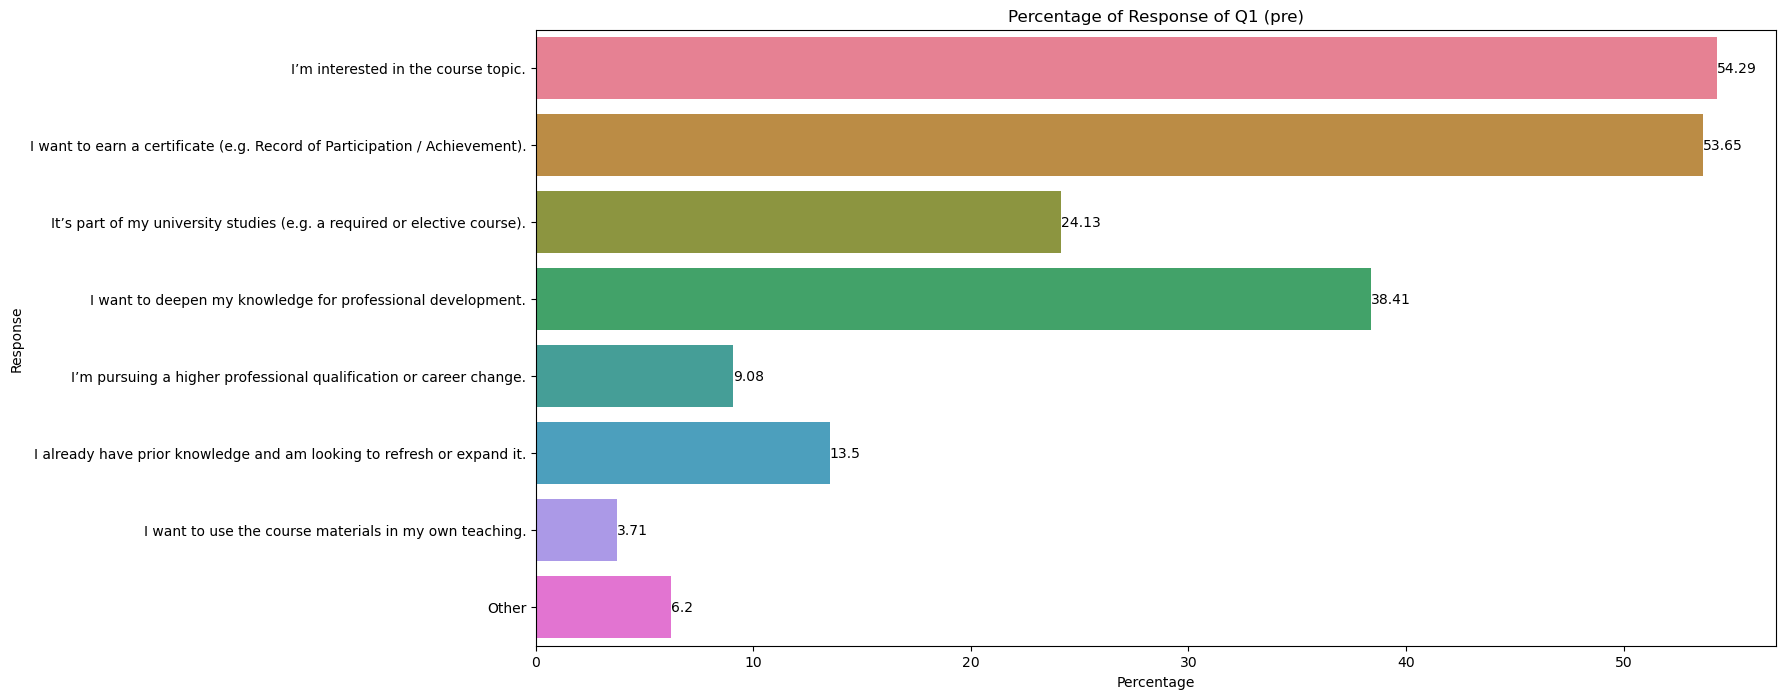

In [220]:
# slice the Question 1
Q1_pre = agg_pre[['Q01_Question 1->I’m interested in the course topic.', \
                  'Q01_Question 1->I want to earn a certificate (e.g. Record of Participation / Achievement).', \
                  'Q01_Question 1->It’s part of my university studies (e.g. a required or elective course).', \
                  'Q01_Question 1->I want to deepen my knowledge for professional development.', \
                  'Q01_Question 1->I’m pursuing a higher professional qualification or career change.', \
                  'Q01_Question 1->I already have prior knowledge and am looking to refresh or expand it.', \
                  'Q01_Question 1->I want to use the course materials in my own teaching.', \
                  'Q01_Question 1->Other']]

Q1_pre.columns = ['I’m interested in the course topic.', \
                  'I want to earn a certificate (e.g. Record of Participation / Achievement).', \
                  'It’s part of my university studies (e.g. a required or elective course).', \
                  'I want to deepen my knowledge for professional development.', \
                  'I’m pursuing a higher professional qualification or career change.', \
                  'I already have prior knowledge and am looking to refresh or expand it.', \
                  'I want to use the course materials in my own teaching.', \
                  'Other']

Q1_pre.isna().sum()
Q1_pre.head()

# check the aggreated frequency
Q1_pct_count_pre = freq_pct_calculator(Q1_pre)

# plotting 
plotting_freq_pct(df = Q1_pct_count_pre, title = 'Percentage of Response of Q1 (pre)')


### Aggregated AI topics of interests (max. 3 responses per individual)

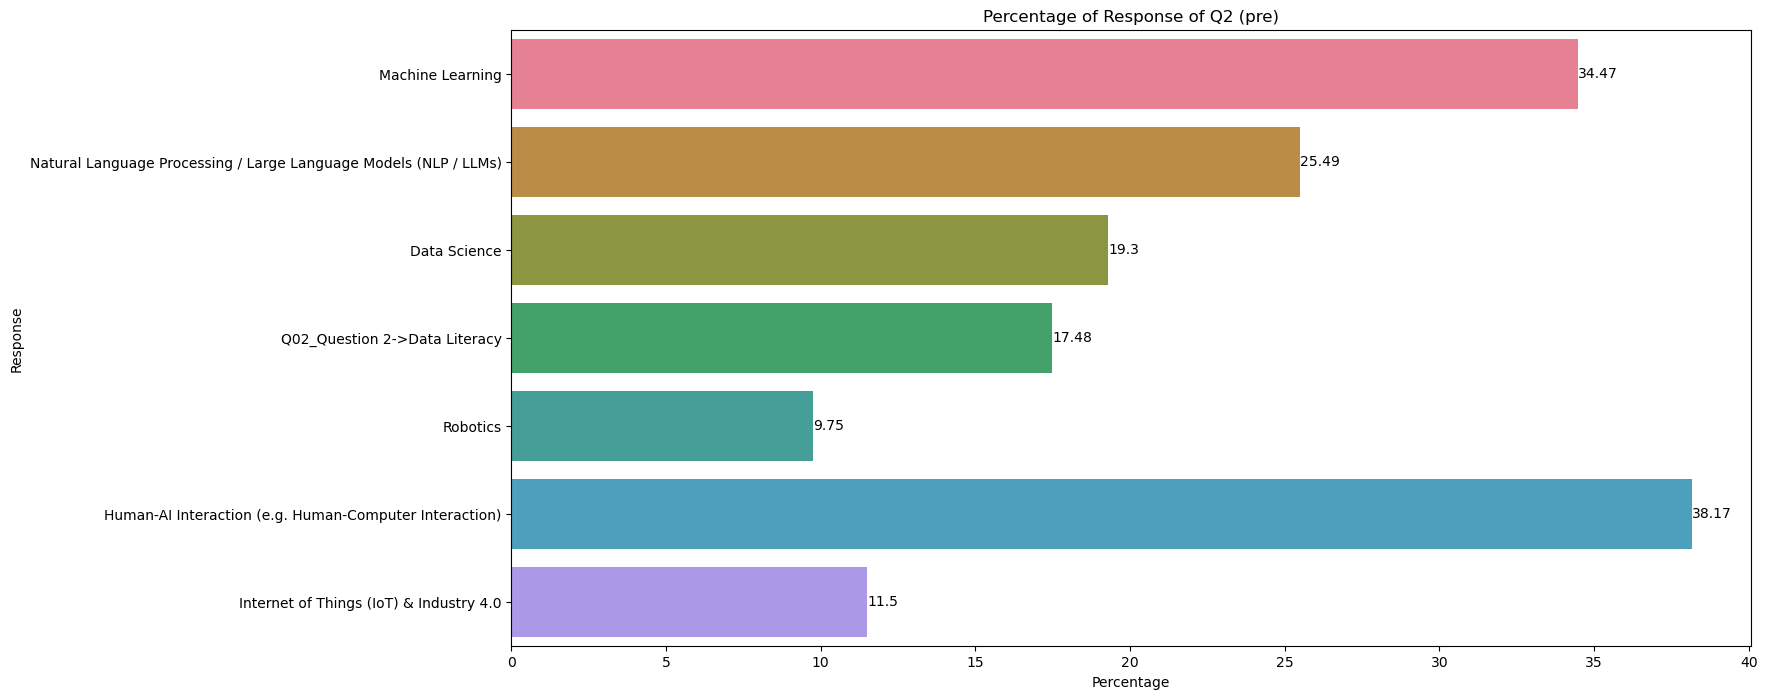

In [219]:
# slice the question 2
Q2_pre = agg_pre[['Q02_Question 2->Machine Learning', \
                  'Q02_Question 2->Natural Language Processing / Large Language Models (NLP / LLMs)', \
                  'Q02_Question 2->Data Science', 'Q02_Question 2->Data Literacy', \
                  'Q02_Question 2->Robotics', \
                  'Q02_Question 2->Human-AI Interaction (e.g. Human-Computer Interaction)', \
                  'Q02_Question 2->Internet of Things (IoT) & Industry 4.0']]

Q2_pre.columns = ['Machine Learning', \
                  'Natural Language Processing / Large Language Models (NLP / LLMs)', \
                  'Data Science', 'Q02_Question 2->Data Literacy', \
                  'Robotics', \
                  'Human-AI Interaction (e.g. Human-Computer Interaction)', \
                  'Internet of Things (IoT) & Industry 4.0']

Q2_pre.isnull().sum()

# check the aggreated frequency
Q2_pct_count_pre = freq_pct_calculator(Q2_pre)

# plotting 
plotting_freq_pct(df = Q2_pct_count_pre, title = 'Percentage of Response of Q2 (pre)')

### Aggregated areas of interests of AI (max. 3 responses per individual)

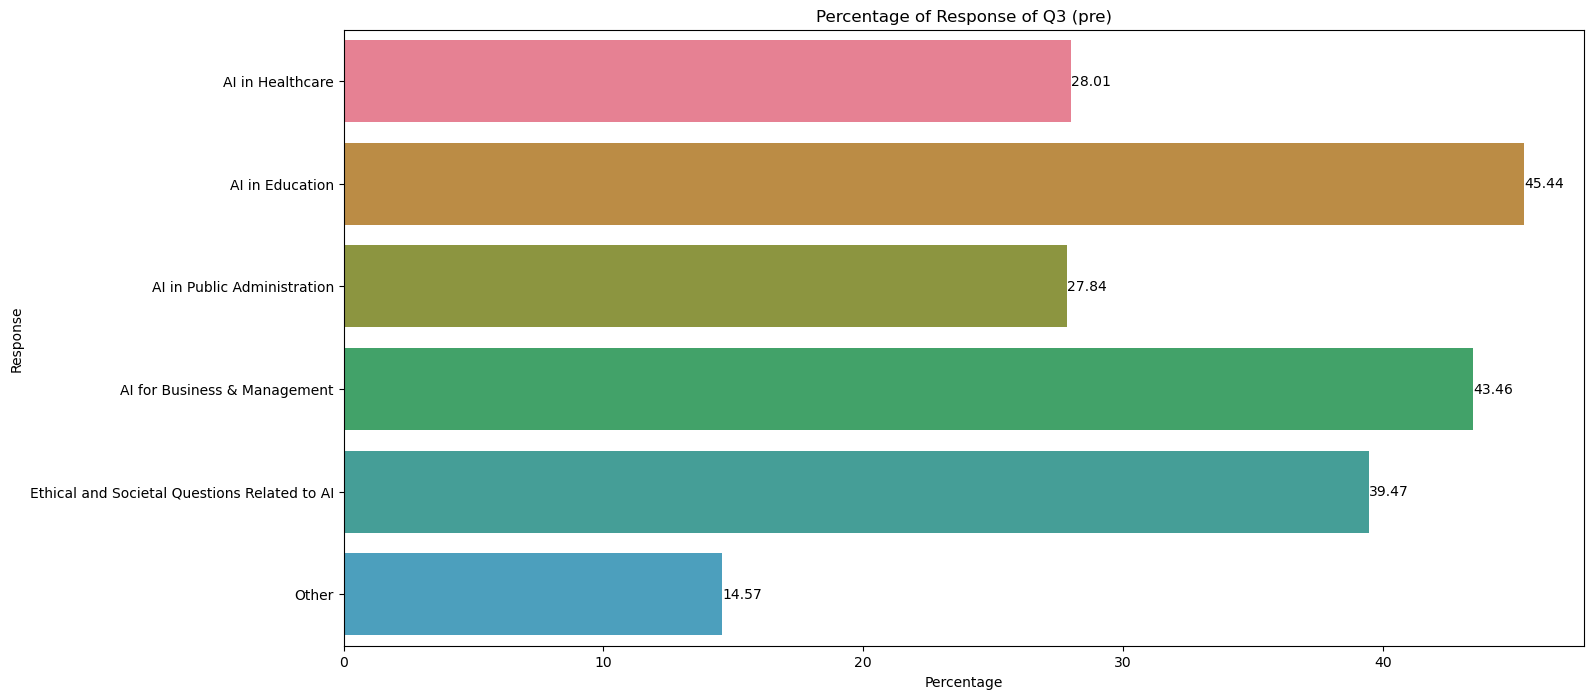

In [218]:
# slice the question Q3
Q3_pre = agg_pre[['Q03_Question 3->AI in Healthcare', \
                  'Q03_Question 3->AI in Education', \
                  'Q03_Question 3->AI in Public Administration', \
                  'Q03_Question 3->AI for Business & Management', \
                  'Q03_Question 3->Ethical and Societal Questions Related to AI', \
                  'Q03_Question 3->Other']]

Q3_pre.columns = ['AI in Healthcare', \
                  'AI in Education', \
                  'AI in Public Administration', \
                  'AI for Business & Management', \
                  'Ethical and Societal Questions Related to AI', \
                  'Other']

Q3_pre.isnull().sum()

# check the aggreated frequency
Q3_pct_count_pre = freq_pct_calculator(Q3_pre)

# plotting 
plotting_freq_pct(df = Q3_pct_count_pre, title = 'Percentage of Response of Q3 (pre)')


### Aggregated number of gender distribution (pre-surveys)

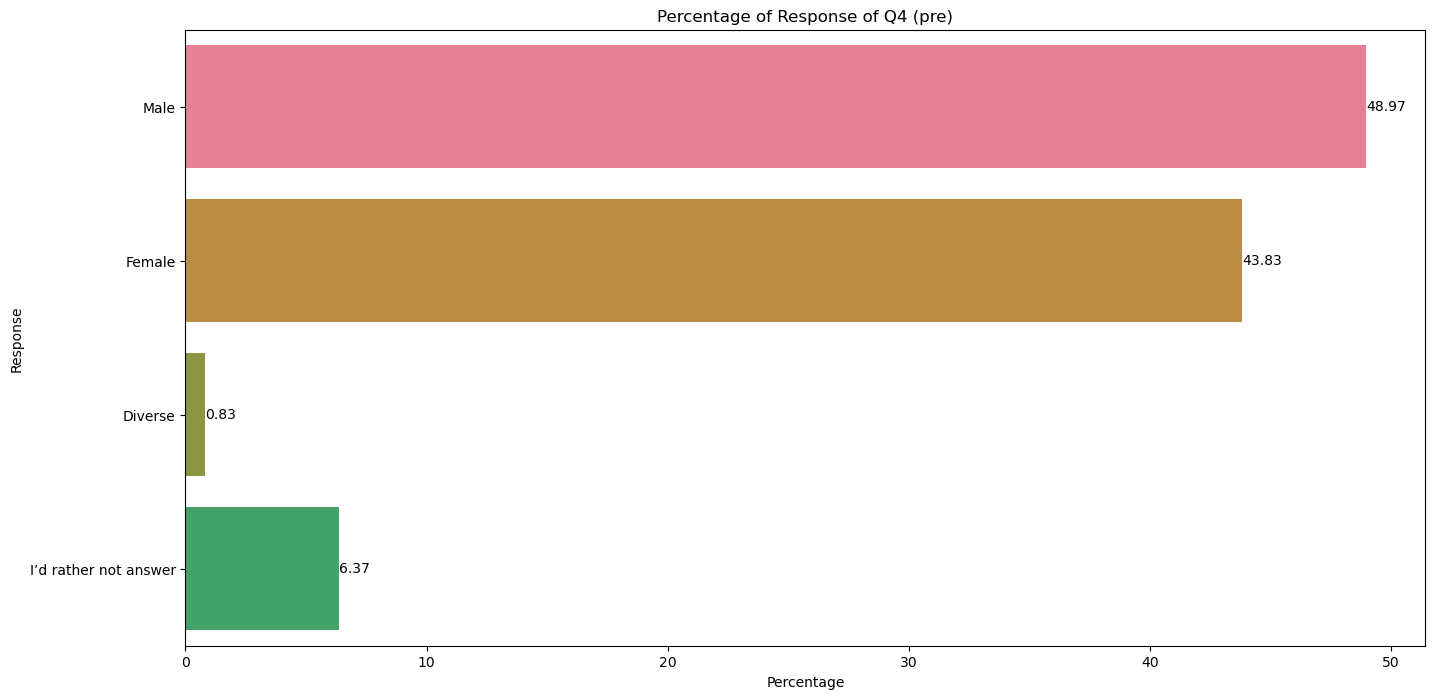

In [217]:
# slice the question Q4
Q4_pre = agg_pre[['Q04_Question 4->Male', \
           'Q04_Question 4->Female', 'Q04_Question 4->Diverse', \
           'Q04_Question 4->I’d rather not answer']]

Q4_pre.columns = ['Male', \
                  'Female', 'Diverse', \
                  'I’d rather not answer']

Q4_pre.isnull().sum()

# check the aggreated frequency
Q4_pct_count_pre = freq_pct_calculator(Q4_pre)

# plotting 
plotting_freq_pct(df = Q4_pct_count_pre, title = 'Percentage of Response of Q4 (pre)')


### Aggregated level of education (pre-surveys)

C:\Users\ywa\AppData\Local\Temp\ipykernel_26356\2829489856.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Q5_pre.columnss = ['Doctorate / PhD', 'Master’s degree or equivalent (e.g. Diplom, Magister, postgraduate university degree)', \


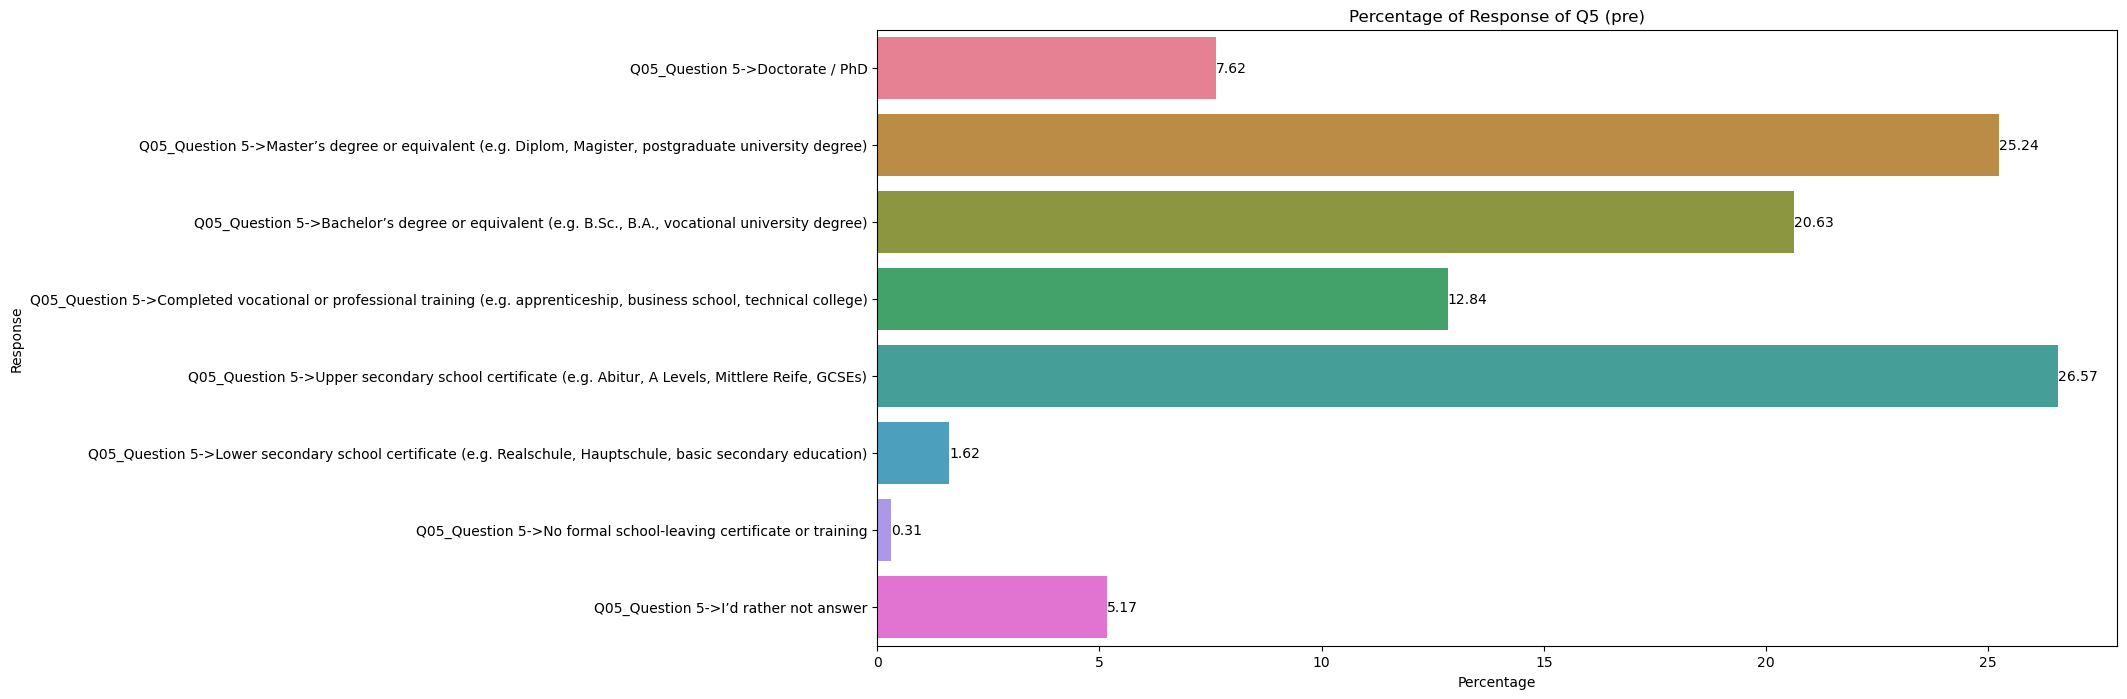

In [216]:
# slice the question Q5

Q5_pre = agg_pre[['Q05_Question 5->Doctorate / PhD', \
                  'Q05_Question 5->Master’s degree or equivalent (e.g. Diplom, Magister, postgraduate university degree)', \
                  'Q05_Question 5->Bachelor’s degree or equivalent (e.g. B.Sc., B.A., vocational university degree)', \
                  'Q05_Question 5->Completed vocational or professional training (e.g. apprenticeship, business school, technical college)', \
                  'Q05_Question 5->Upper secondary school certificate (e.g. Abitur, A Levels, Mittlere Reife, GCSEs)', \
                  'Q05_Question 5->Lower secondary school certificate (e.g. Realschule, Hauptschule, basic secondary education)', \
                  'Q05_Question 5->No formal school-leaving certificate or training', \
                  'Q05_Question 5->I’d rather not answer']]

Q5_pre.columnss = ['Doctorate / PhD', 'Master’s degree or equivalent (e.g. Diplom, Magister, postgraduate university degree)', \
                   'Bachelor’s degree or equivalent (e.g. B.Sc., B.A., vocational university degree)', \
                   'Completed vocational or professional training (e.g. apprenticeship, business school, technical college)', \
                   'Upper secondary school certificate (e.g. Abitur, A Levels, Mittlere Reife, GCSEs)', \
                   'Lower secondary school certificate (e.g. Realschule, Hauptschule, basic secondary education)', \
                   'No formal school-leaving certificate or training', \
                   'I’d rather not answer']

Q5_pre.isnull().sum()

# check the aggreated frequency
Q5_pct_count_pre = freq_pct_calculator(Q5_pre)

# plotting 
plotting_freq_pct(df = Q5_pct_count_pre, title = 'Percentage of Response of Q5 (pre)')

### Aggregated employment (pre-surveys)

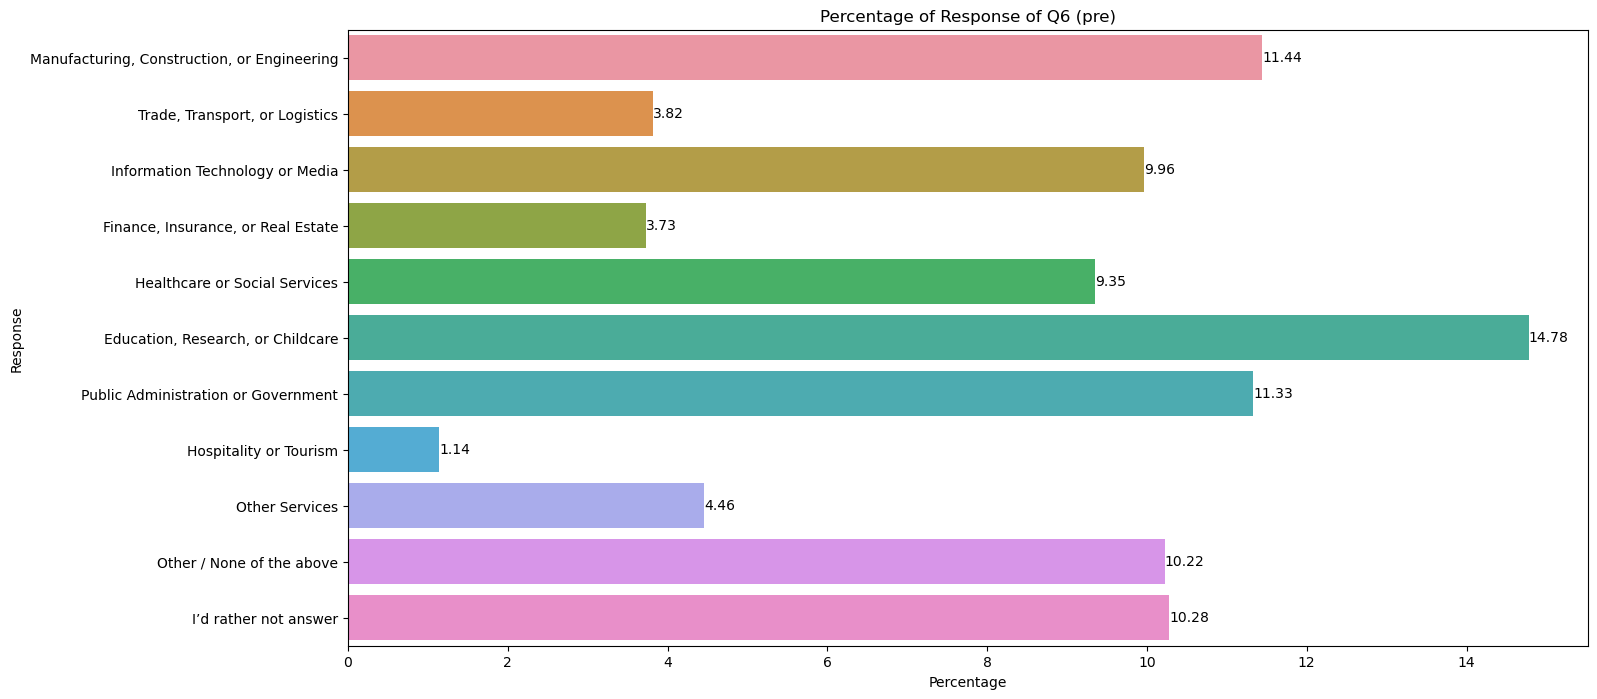

In [215]:
# slice the question Q6

Q6_pre = agg_pre[['Q06_Question 6->Manufacturing, Construction, or Engineering', \
                 'Q06_Question 6->Trade, Transport, or Logistics', \
                 'Q06_Question 6->Information Technology or Media', \
                 'Q06_Question 6->Finance, Insurance, or Real Estate', \
                 'Q06_Question 6->Healthcare or Social Services', \
                 'Q06_Question 6->Education, Research, or Childcare', \
                 'Q06_Question 6->Public Administration or Government', \
                 'Q06_Question 6->Hospitality or Tourism', \
                 'Q06_Question 6->Other Services', \
                 'Q06_Question 6->Other / None of the above', \
                 'Q06_Question 6->I’d rather not answer']]

Q6_pre.columns = ['Manufacturing, Construction, or Engineering', \
                  'Trade, Transport, or Logistics', \
                  'Information Technology or Media', \
                  'Finance, Insurance, or Real Estate', \
                  'Healthcare or Social Services', \
                  'Education, Research, or Childcare', \
                  'Public Administration or Government', \
                  'Hospitality or Tourism', \
                  'Other Services', \
                  'Other / None of the above', \
                  'I’d rather not answer']

Q6_pre.isnull().sum()

# check the aggreated frequency
Q6_pct_count_pre = freq_pct_calculator(Q6_pre)

# plotting 
plotting_freq_pct(df = Q6_pct_count_pre, title = 'Percentage of Response of Q6 (pre)')

### Course impression

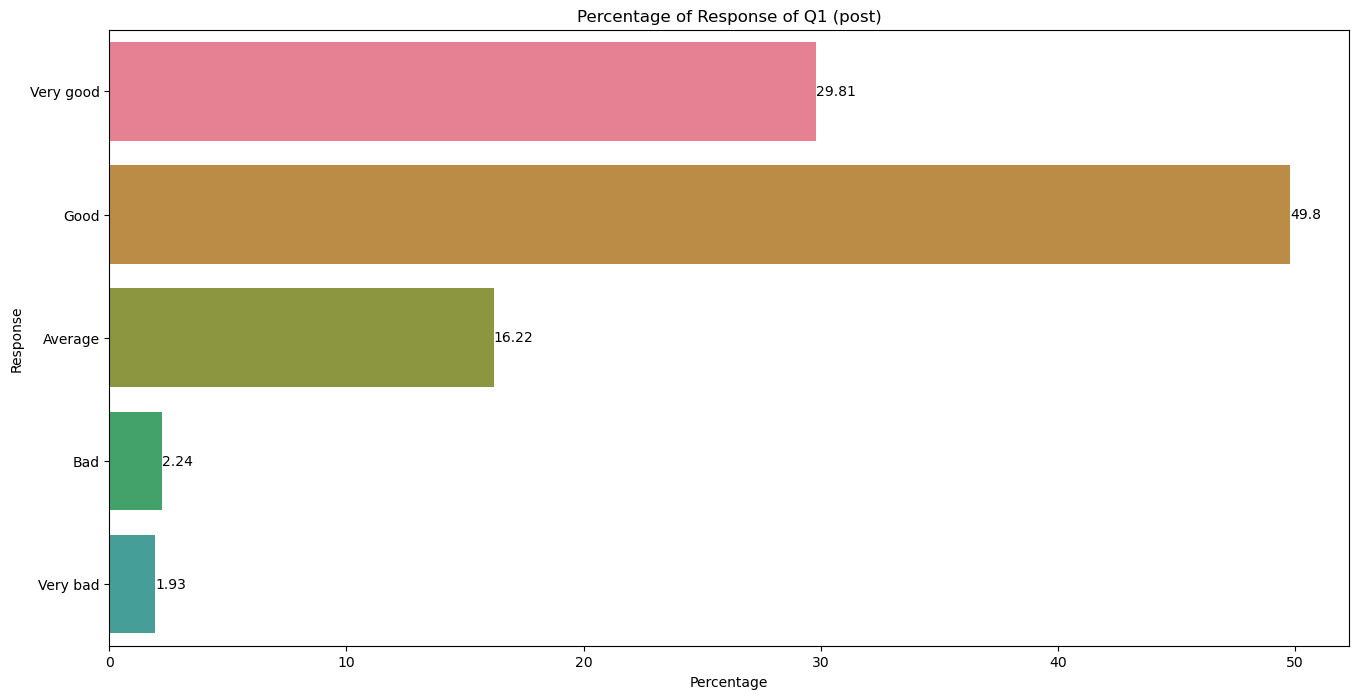

In [209]:
# slice the question Q1
Q1_post = agg_post[['Q01_Question 1->Very good', \
                    'Q01_Question 1->Good', \
                    'Q01_Question 1->Average', \
                    'Q01_Question 1->Bad', \
                    'Q01_Question 1->Very bad']]

Q1_post.columns = ['Very good', \
                   'Good', \
                   'Average', \
                   'Bad', \
                   'Very bad']

Q1_post.isnull().sum()

# check the aggreated frequency
Q1_pct_count_post = freq_pct_calculator(Q1_post)

# plotting 
plotting_freq_pct(df = Q1_pct_count_post, title = 'Percentage of Response of Q1 (post)')

### Course recommendation

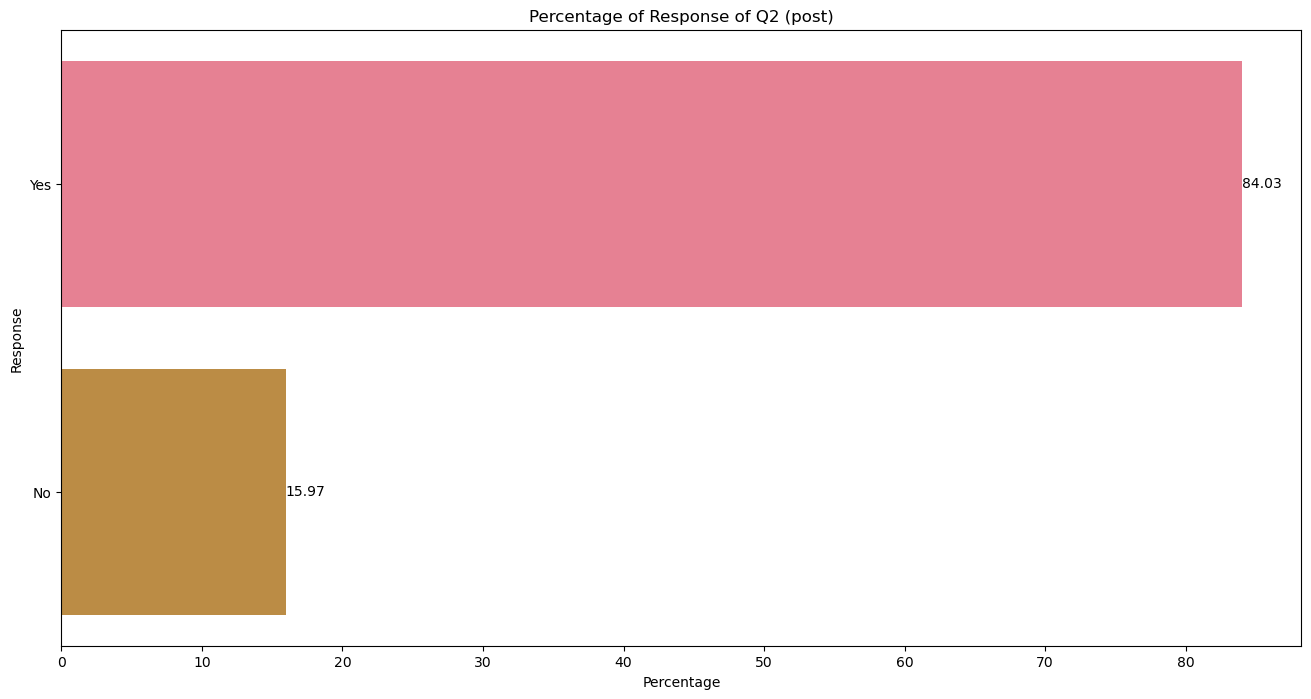

In [222]:
Q2_post = agg_post[['Q02_Question 2->Yes', 'Q02_Question 2->No']]

Q2_post.columns = ['Yes', 'No']

Q2_post.isnull().sum()

# check the aggreated frequency
Q2_pct_count_post = freq_pct_calculator(Q2_post)

# plotting 
plotting_freq_pct(df = Q2_pct_count_post, title = 'Percentage of Response of Q2 (post)')

### Reasons for not recommending the course

C:\Users\ywa\AppData\Local\Temp\ipykernel_26356\4293986516.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  Q3_post.columsn = ['The content was not accurate or up-to-date', \


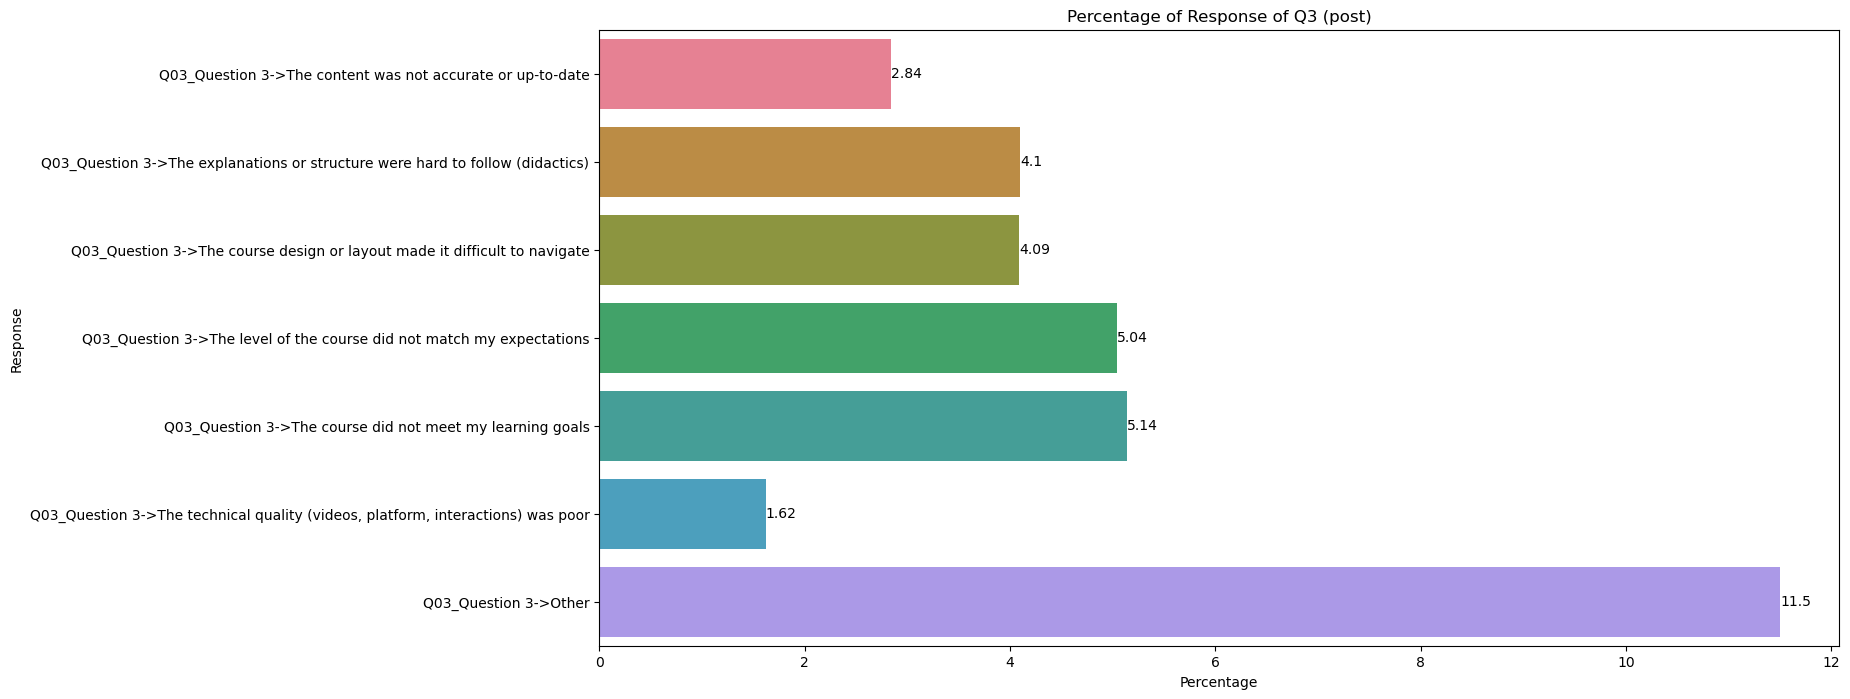

In [225]:
Q3_post = agg_post[['Q03_Question 3->The content was not accurate or up-to-date', \
                    'Q03_Question 3->The explanations or structure were hard to follow (didactics)', \
                    'Q03_Question 3->The course design or layout made it difficult to navigate', \
                    'Q03_Question 3->The level of the course did not match my expectations', \
                    'Q03_Question 3->The course did not meet my learning goals', \
                    'Q03_Question 3->The technical quality (videos, platform, interactions) was poor', \
                    'Q03_Question 3->Other']]

Q3_post.columsn = ['The content was not accurate or up-to-date', \
                   'The explanations or structure were hard to follow (didactics)', \
                   'The course design or layout made it difficult to navigate', \
                   'The level of the course did not match my expectations', \
                   'The course did not meet my learning goals', \
                   'The technical quality (videos, platform, interactions) was poor', \
                   'Other']

Q3_post.isnull().sum()

# check the aggreated frequency
Q3_pct_count_post = freq_pct_calculator(Q3_post)

# plotting 
plotting_freq_pct(df = Q3_pct_count_post, title = 'Percentage of Response of Q3 (post)')


### Subjective preceived learning goal

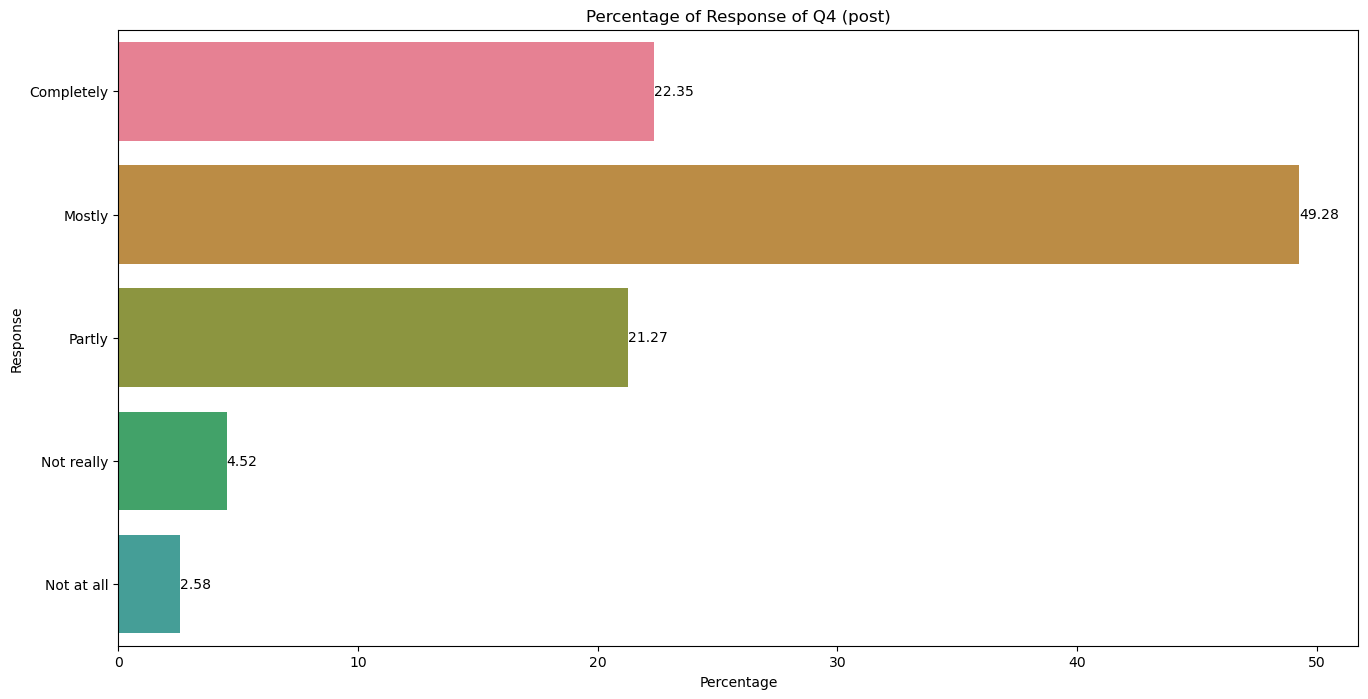

In [227]:
Q4_post = agg_post[['Q04_Question 4->Completely', \
                    'Q04_Question 4->Mostly', \
                    'Q04_Question 4->Partly', \
                    'Q04_Question 4->Not really', \
                    'Q04_Question 4->Not at all']]

Q4_post.columns = ['Completely', \
                   'Mostly', \
                   'Partly', \
                   'Not really', \
                   'Not at all']

Q4_post.isnull().sum()

# check the aggreated frequency
Q4_pct_count_post = freq_pct_calculator(Q4_post)

# plotting 
plotting_freq_pct(df = Q4_pct_count_post, title = 'Percentage of Response of Q4 (post)')

### Subjective knowedge estimation pre-course

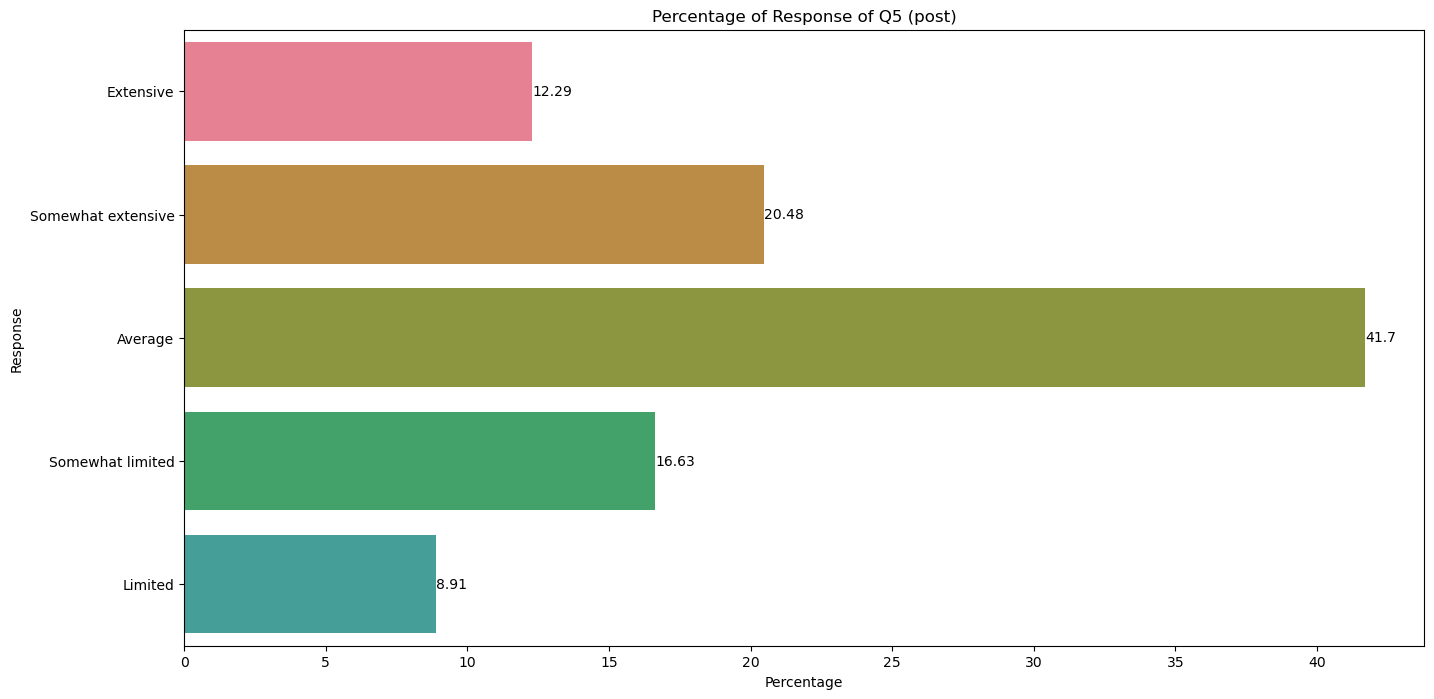

In [228]:
Q5_post = agg_post[['Q05_Question 5->Extensive', \
                    'Q05_Question 5->Somewhat extensive', \
                    'Q05_Question 5->Average', \
                    'Q05_Question 5->Somewhat limited', \
                    'Q05_Question 5->Limited']]

Q5_post.columns = ['Extensive', \
                   'Somewhat extensive', \
                   'Average', \
                   'Somewhat limited', \
                   'Limited']

Q5_post.isnull().sum()

# check the aggreated frequency
Q5_pct_count_post = freq_pct_calculator(Q5_post)

# plotting 
plotting_freq_pct(df = Q5_pct_count_post, title = 'Percentage of Response of Q5 (post)')

### Subjective knowledge estimation post-course

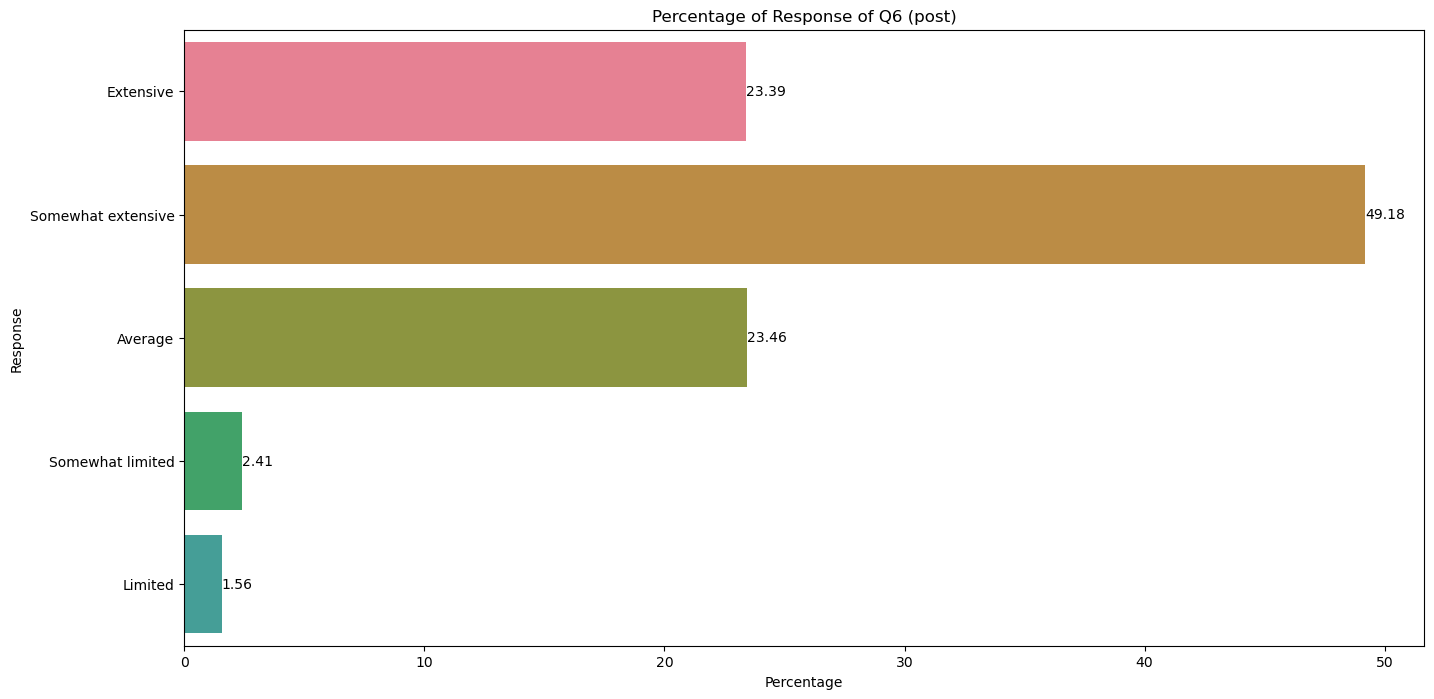

In [230]:
Q6_post = agg_post[['Q06_Question 6->Extensive', \
                    'Q06_Question 6->Somewhat extensive', \
                    'Q06_Question 6->Average', \
                    'Q06_Question 6->Somewhat limited', \
                    'Q06_Question 6->Limited']]

Q6_post.columns = ['Extensive', \
                   'Somewhat extensive', \
                   'Average', \
                   'Somewhat limited', \
                   'Limited']

Q6_post.isnull().sum()

# check the aggreated frequency
Q6_pct_count_post = freq_pct_calculator(Q6_post)

# plotting 
plotting_freq_pct(df = Q6_pct_count_post, title = 'Percentage of Response of Q6 (post)')


### Most supportive activity type (max. 3 responses per individual)

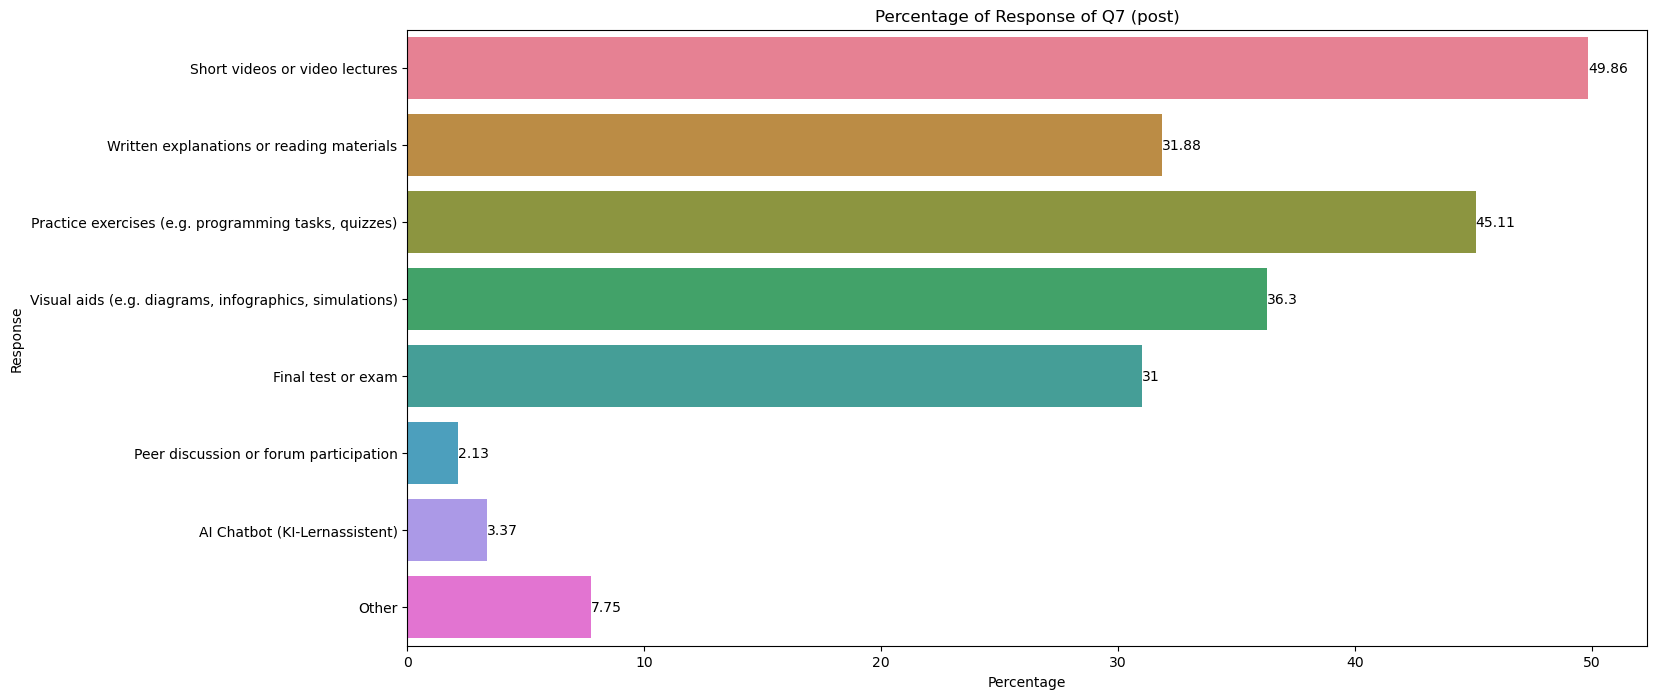

In [234]:
Q7_post = agg_post[['Q07_Question 7->Short videos or video lectures', \
                    'Q07_Question 7->Written explanations or reading materials', \
                    'Q07_Question 7->Practice exercises (e.g. programming tasks, quizzes)', \
                    'Q07_Question 7->Visual aids (e.g. diagrams, infographics, simulations)', \
                    'Q07_Question 7->Final test or exam', \
                    'Q07_Question 7->Peer discussion or forum participation', \
                    'Q07_Question 7->AI Chatbot (KI-Lernassistent)', \
                    'Q07_Question 7->Other']]

Q7_post.columns = ['Short videos or video lectures', \
                   'Written explanations or reading materials', \
                   'Practice exercises (e.g. programming tasks, quizzes)', \
                   'Visual aids (e.g. diagrams, infographics, simulations)', \
                   'Final test or exam', \
                   'Peer discussion or forum participation', \
                   'AI Chatbot (KI-Lernassistent)', \
                   'Other']

Q7_post.isnull().sum()

# check the aggreated frequency
Q7_pct_count_post = freq_pct_calculator(Q7_post)

# plotting 
plotting_freq_pct(df = Q7_pct_count_post, title = 'Percentage of Response of Q7 (post)')


### Chatbot (learning assisstant) use

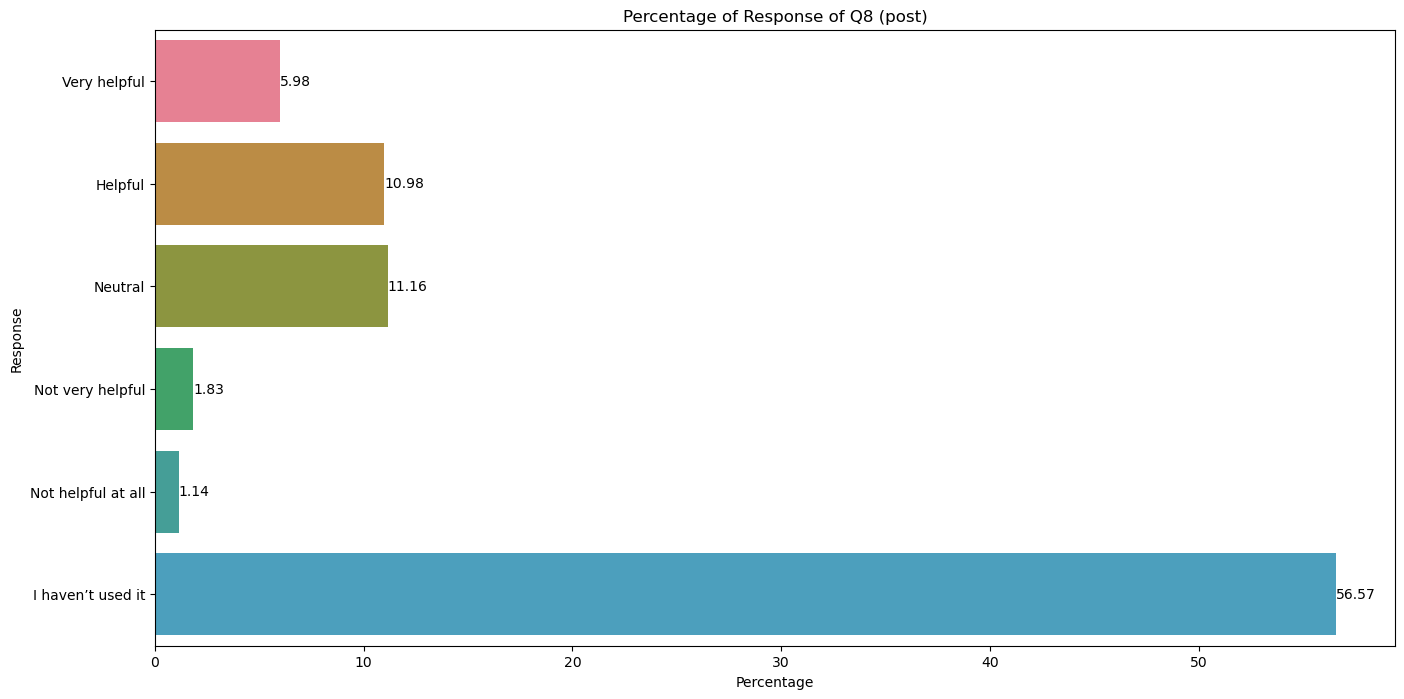

In [237]:
Q8_post = agg_post[['Q08_Question 8->Very helpful', \
                    'Q08_Question 8->Helpful', \
                    'Q08_Question 8->Neutral', \
                    'Q08_Question 8->Not very helpful', \
                    'Q08_Question 8->Not helpful at all', \
                    'Q08_Question 8->I haven’t used it']]

Q8_post.columns = ['Very helpful', \
                   'Helpful', \
                   'Neutral', \
                   'Not very helpful', \
                   'Not helpful at all', \
                   'I haven’t used it']

Q8_post.isnull().sum()

# check the aggreated frequency
Q8_pct_count_post = freq_pct_calculator(Q8_post)

# plotting 
plotting_freq_pct(df = Q8_pct_count_post, title = 'Percentage of Response of Q8 (post)')

### Purpose of Chatbot use

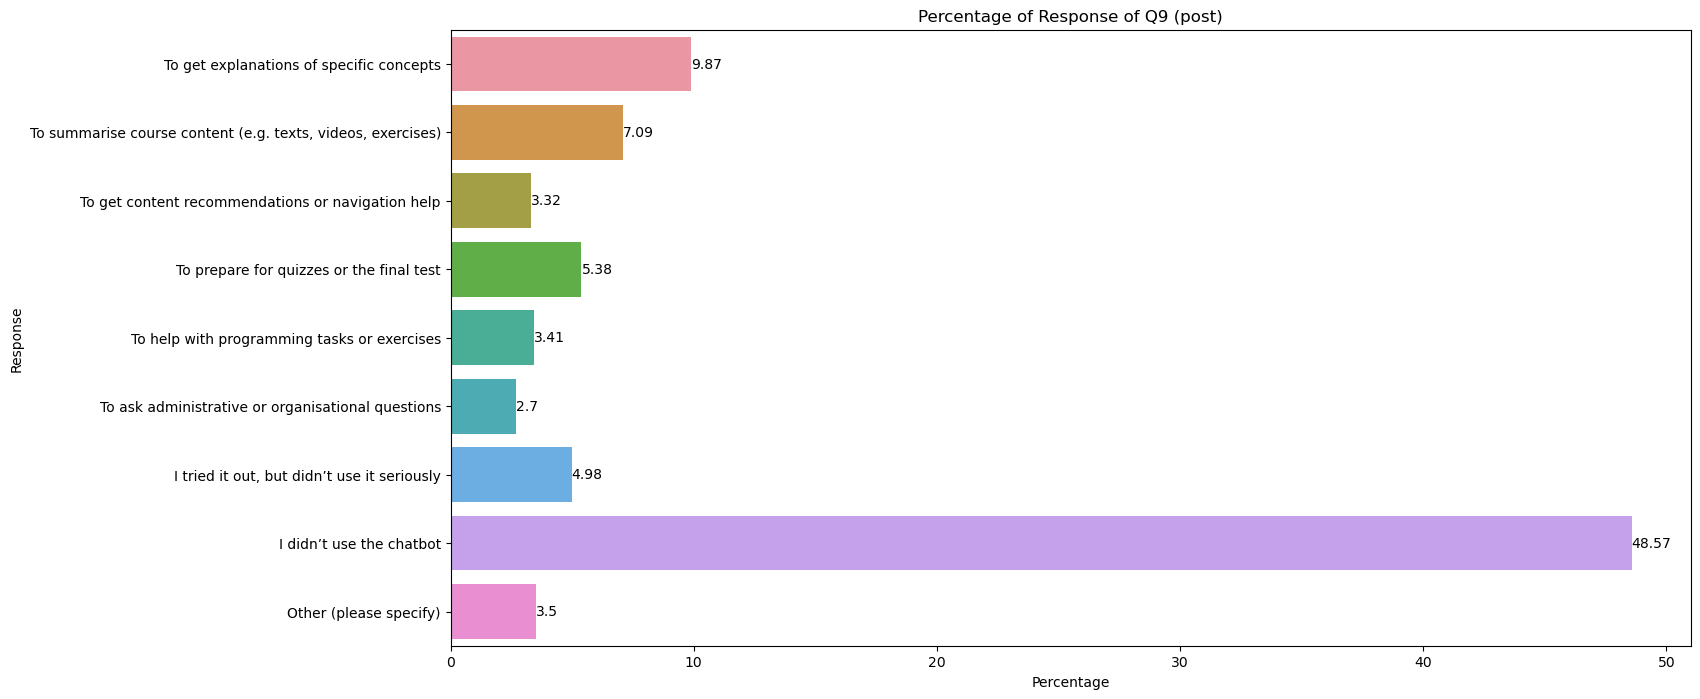

In [240]:
Q9_post = agg_post[['Q09_Question 9->To get explanations of specific concepts', \
                    'Q09_Question 9->To summarise course content (e.g. texts, videos, exercises)', \
                    'Q09_Question 9->To get content recommendations or navigation help', \
                    'Q09_Question 9->To prepare for quizzes or the final test', \
                    'Q09_Question 9->To help with programming tasks or exercises', \
                    'Q09_Question 9->To ask administrative or organisational questions', \
                    'Q09_Question 9->I tried it out, but didn’t use it seriously', \
                    'Q09_Question 9->I didn’t use the chatbot', \
                    'Q09_Question 9->Other (please specify)']]

Q9_post.columns = ['To get explanations of specific concepts', \
                   'To summarise course content (e.g. texts, videos, exercises)', \
                   'To get content recommendations or navigation help', \
                   'To prepare for quizzes or the final test', \
                   'To help with programming tasks or exercises', \
                   'To ask administrative or organisational questions', \
                   'I tried it out, but didn’t use it seriously', \
                   'I didn’t use the chatbot', \
                   'Other (please specify)']

Q9_post.isnull().sum()

# check the aggreated frequency
Q9_pct_count_post = freq_pct_calculator(Q9_post)

# plotting 
plotting_freq_pct(df = Q9_pct_count_post, title = 'Percentage of Response of Q9 (post)')

### Aggregated number of gender distribution (post-surveys)

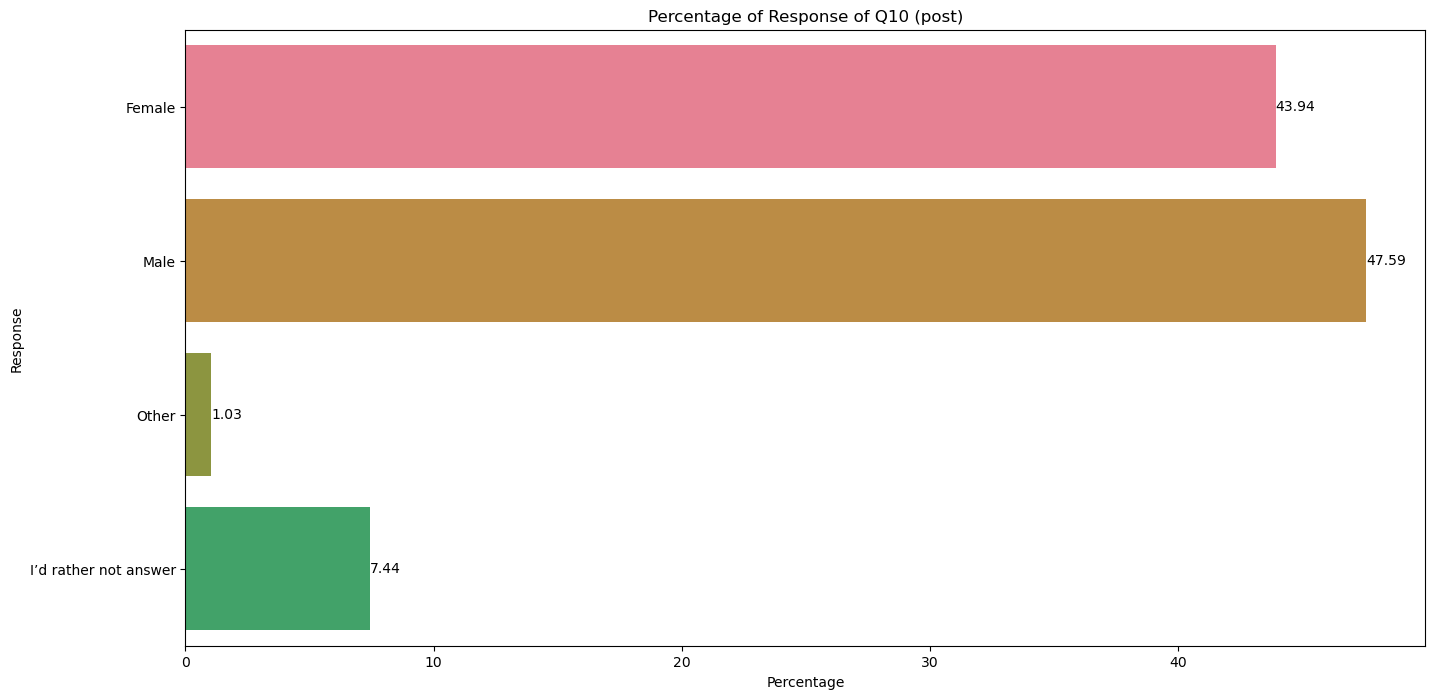

In [249]:
Q10_post = agg_post[['Q10_Question 10->Female', \
                     'Q10_Question 10->Male', \
                     'Q10_Question 10->Other', \
                     'Q10_Question 10->I’d rather not answer']]

Q10_post.columns = ['Female', \
                    'Male', \
                    'Other', \
                    'I’d rather not answer']

Q10_post.isnull().sum()

# check the aggreated frequency
Q10_pct_count_post = freq_pct_calculator(Q10_post)

# plotting 
plotting_freq_pct(df = Q10_pct_count_post, title = 'Percentage of Response of Q10 (post)')

### Aggregated level of education (pre-surveys)

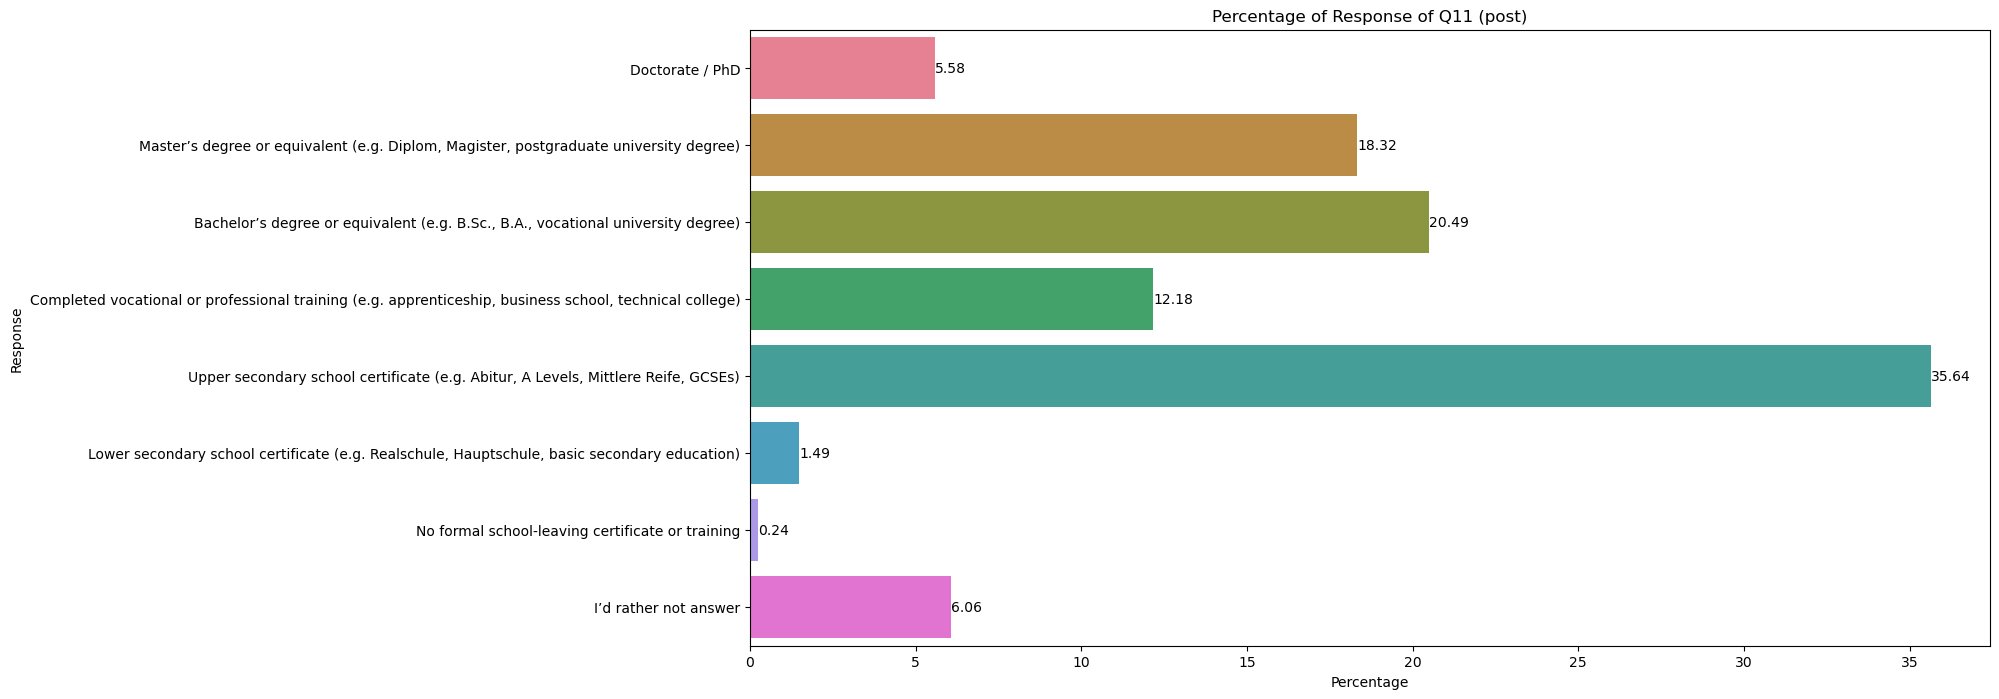

In [250]:
Q11_post = agg_post[['Q11_Question 11->Doctorate / PhD', \
                     'Q11_Question 11->Master’s degree or equivalent (e.g. Diplom, Magister, postgraduate university degree)', \
                     'Q11_Question 11->Bachelor’s degree or equivalent (e.g. B.Sc., B.A., vocational university degree)', \
                     'Q11_Question 11->Completed vocational or professional training (e.g. apprenticeship, business school, technical college)', \
                     'Q11_Question 11->Upper secondary school certificate (e.g. Abitur, A Levels, Mittlere Reife, GCSEs)', \
                     'Q11_Question 11->Lower secondary school certificate (e.g. Realschule, Hauptschule, basic secondary education)', \
                     'Q11_Question 11->No formal school-leaving certificate or training', \
                     'Q11_Question 11->I’d rather not answer']]

Q11_post.columns = ['Doctorate / PhD', \
                    'Master’s degree or equivalent (e.g. Diplom, Magister, postgraduate university degree)', \
                    'Bachelor’s degree or equivalent (e.g. B.Sc., B.A., vocational university degree)', \
                    'Completed vocational or professional training (e.g. apprenticeship, business school, technical college)', \
                    'Upper secondary school certificate (e.g. Abitur, A Levels, Mittlere Reife, GCSEs)', \
                    'Lower secondary school certificate (e.g. Realschule, Hauptschule, basic secondary education)', \
                    'No formal school-leaving certificate or training', \
                    'I’d rather not answer']

Q11_post.isnull().sum()

# check the aggreated frequency
Q11_pct_count_post = freq_pct_calculator(Q11_post)

# plotting 
plotting_freq_pct(df = Q11_pct_count_post, title = 'Percentage of Response of Q11 (post)')


### Aggregated employment (pre-surveys)

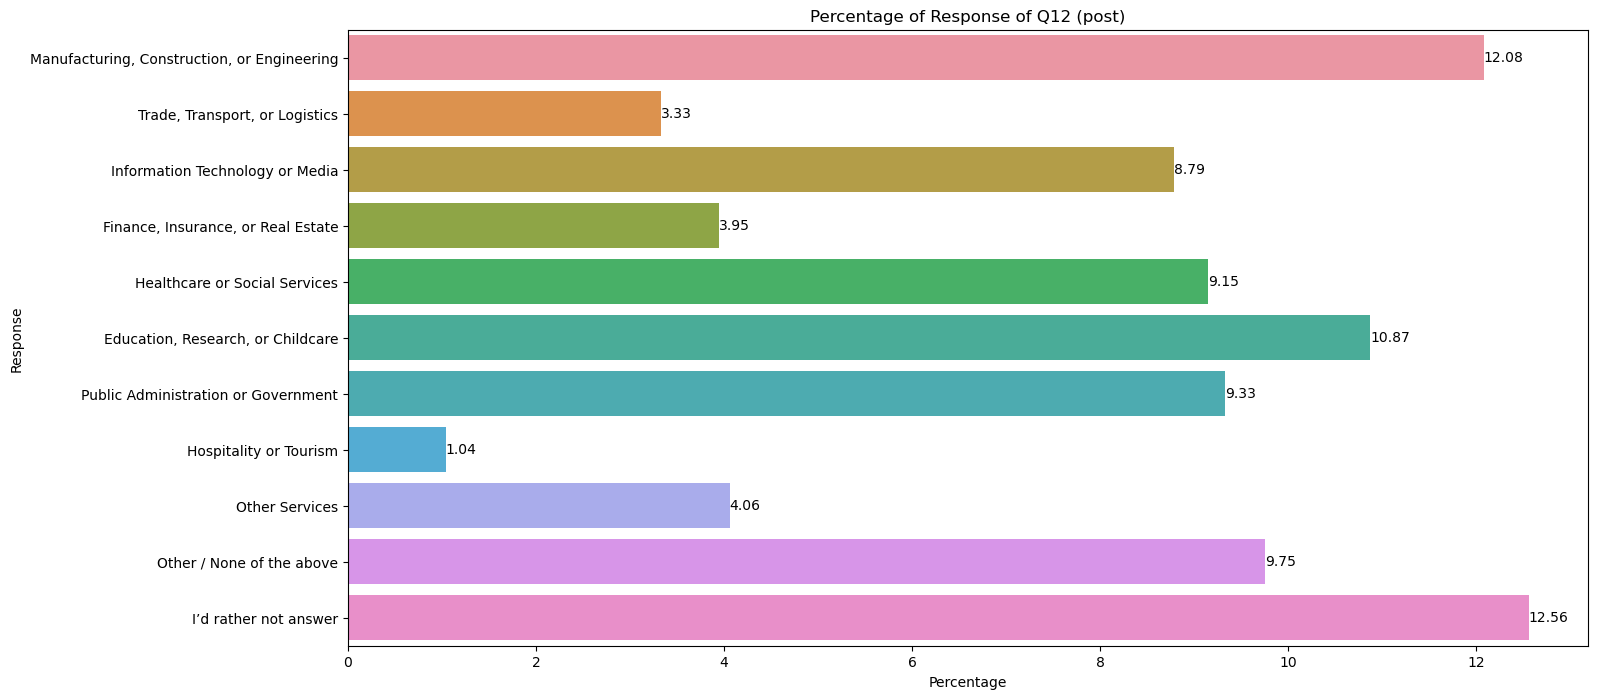

In [251]:
Q12_post = agg_post[['Q12_Question 12->Manufacturing, Construction, or Engineering', \
                     'Q12_Question 12->Trade, Transport, or Logistics', \
                     'Q12_Question 12->Information Technology or Media', \
                     'Q12_Question 12->Finance, Insurance, or Real Estate', \
                     'Q12_Question 12->Healthcare or Social Services', \
                     'Q12_Question 12->Education, Research, or Childcare', \
                     'Q12_Question 12->Public Administration or Government', \
                     'Q12_Question 12->Hospitality or Tourism', \
                     'Q12_Question 12->Other Services', \
                     'Q12_Question 12->Other / None of the above', \
                     'Q12_Question 12->I’d rather not answer']]

Q12_post.columns =  ['Manufacturing, Construction, or Engineering', \
                     'Trade, Transport, or Logistics', \
                     'Information Technology or Media', \
                     'Finance, Insurance, or Real Estate', \
                     'Healthcare or Social Services', \
                     'Education, Research, or Childcare', \
                     'Public Administration or Government', \
                     'Hospitality or Tourism', \
                     'Other Services', \
                     'Other / None of the above', \
                     'I’d rather not answer']

Q12_post.isnull().sum()

# check the aggreated frequency
Q12_pct_count_post = freq_pct_calculator(Q12_post)

# plotting 
plotting_freq_pct(df = Q12_pct_count_post, title = 'Percentage of Response of Q12 (post)')

## For single course